<a href="https://colab.research.google.com/github/QwertyJacob/smartCDN/blob/master/Training_Cycles_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!pip install torchviz

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torchviz import make_dot
from torch.nn import functional as F
import random
from collections import defaultdict
import time, datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np


# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

path = "/content/drive/My Drive/Colab Notebooks/ds/"

     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=f2e48ec90b340d31f84b997b90a1a24394042dff6198424e2f08d86f351fe4f7
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [ ]:
#GPU count and name
!nvidia-smi -L

!lscpu |grep 'Model name'

#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

!lscpu | grep "L3 cache" 

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at shown frequency
!lscpu | grep "MHz"

! echo memory that we can use

!free -h --si | awk  '/Mem:/{print $2}'

! echo hard disk space that we can use
!df -h / | awk '{print $4}'

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-f97c1011-8b92-5f03-41fa-b8ece6f0802e)
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Socket(s):           1
Core(s) per socket:  1
Thread(s) per core:  2
L3 cache:            39424K
CPU MHz:             2000.168
memory that we can use
13G
hard disk space that we can use
Avail
111G


### Network Parameters: (constants) CHECKPOINTED-AVOIDABLE
_____

In [16]:
import torch
import pickle



'''
Number of NVF hosts
'''
N_h = 16


'''
Number of Content Providers
'''
N_cp = 41


'''
Number of Client clusters
'''
N_uc = 4


init_random_bandwidths = True
init_random_resource_provisioning = True


'''
NETWORK DELAYS:
'''
min_core_delay = 220
max_core_delay = 500

min_mesh_delay = 20
max_mesh_delay = 30

min_edge_delay = 8
max_edge_delay = 20

'''
Propagation delays among network nodes.
'''

#Core Delay Tensor
cD = (min_core_delay - max_core_delay) * torch.rand(N_cp, N_h, requires_grad=False) + max_core_delay
#Mesh Delay Tensor:
mD = (min_mesh_delay - max_mesh_delay) * torch.rand(N_h, N_h, requires_grad=False) + max_mesh_delay
#Mesh Delay Must be Simmetric!!!!
mD = (mD + torch.transpose(mD,0,1))/2
#Absolute Edge Delay Tensor:
eD = (min_edge_delay - max_edge_delay) * torch.rand(N_uc, N_h, requires_grad=False) + max_edge_delay


'''
Data transfer costs among network nodes.
'''
#Min/Max Delay:
min_core_dt_cost = 88
max_core_dt_cost = 100

min_mesh_dt_cost = 4
max_mesh_dt_cost = 20

min_edge_dt_cost = 0
max_edge_dt_cost = 0



#Core DTCOST Tensor
core_DT_costs = (min_core_dt_cost - max_core_dt_cost) * torch.rand(N_cp, N_h, requires_grad=False) + max_core_dt_cost
#Mesh DTCOST Tensor:
mesh_DT_costs = (min_mesh_dt_cost - max_mesh_dt_cost) * torch.rand(N_h, N_h, requires_grad=False) + max_mesh_dt_cost
#Mesh DTCOST Must be Simmetric!!!!
mesh_DT_costs = (mesh_DT_costs + torch.transpose(mesh_DT_costs,0,1))/2
#Absolute Edge DTCOST Tensor:
edge_DT_costs = (min_edge_dt_cost - max_edge_dt_cost) * torch.rand(N_uc, N_h,  requires_grad=False) + max_edge_dt_cost



'''
NETWORK BANDWIDTH:
- The bitrates are scaled. i.e. the max bitrate for a session is 1. 
'''
min_core_bandwidth = 1
max_core_bandwidth = 1

min_mesh_bandwidth = 20
max_mesh_bandwidth = 70

min_edge_bandwidth = 20
max_edge_bandwidth = 70




#Core Bandwidth Tensor
cB = (min_core_bandwidth - max_core_bandwidth) * torch.rand(N_cp, N_h, requires_grad=False) + max_core_bandwidth
#Mesh Bandwidth Tensor:
mB = (min_mesh_bandwidth - max_mesh_bandwidth) * torch.rand(N_h, N_h, requires_grad=False) + max_mesh_bandwidth
#Mesh Bandwidth Must be Simmetric!!!!
mB = (mB + torch.transpose(mB,0,1))/2

#Edge Bandwidth Tensor:
eB = (min_edge_bandwidth - max_edge_bandwidth) * torch.rand(N_uc, N_h,  requires_grad=False) + max_edge_bandwidth


'''
saving to disk
'''

dspath = "/content/drive/My Drive/Colab Notebooks/ds/"


with open( dspath + "corePropDelays.txt", "wb") as fp:   #Pickling
  pickle.dump(cD, fp)

with open( dspath + "meshPropDelays.txt", "wb") as fp:   #Pickling
  pickle.dump(mD, fp)

with open( dspath + "edgePropDelays.txt", "wb") as fp:   #Pickling
  pickle.dump(eD, fp)

with open(dspath + "coreDTCosts.txt", "wb") as fp:  # Pickling
  pickle.dump(core_DT_costs, fp)

with open(dspath + "meshDTCosts.txt", "wb") as fp:  # Pickling
  pickle.dump(mesh_DT_costs, fp)

with open(dspath + "edgeDTCosts.txt", "wb") as fp:  # Pickling
  pickle.dump(edge_DT_costs, fp)

with open(dspath + "coreBandWidths.txt", "wb") as fp:  # Pickling
  pickle.dump(cB, fp)

with open(dspath + "meshBandWidths.txt", "wb") as fp:  # Pickling
  pickle.dump(mB, fp)

with open(dspath + "edgeBandWidths.txt", "wb") as fp:  # Pickling
  pickle.dump(eB, fp)

### Environment Simulator:
______

Run this cell to create the CDNSimulator Class. 

In [2]:
ds_path = "/content/drive/My Drive/Colab Notebooks/ds/"
scalers_path = "/content/drive/My Drive/Colab Notebooks/scalers/"

In [5]:
import torch
import datetime
from collections import defaultdict
import pickle
import random
import joblib
import math


import cProfile
import pstats
from functools import wraps



def profile(output_file=None, sort_by='cumulative', lines_to_print=None, strip_dirs=False):
    """A time profiler decorator.
    Inspired by and modified the profile decorator of Giampaolo Rodola:
    http://code.activestate.com/recipes/577817-profile-decorator/
    Args:
        output_file: str or None. Default is None
            Path of the output file. If only name of the file is given, it's
            saved in the current directory.
            If it's None, the name of the decorated function is used.
        sort_by: str or SortKey enum or tuple/list of str/SortKey enum
            Sorting criteria for the Stats object.
            For a list of valid string and SortKey refer to:
            https://docs.python.org/3/library/profile.html#pstats.Stats.sort_stats
        lines_to_print: int or None
            Number of lines to print. Default (None) is for all the lines.
            This is useful in reducing the size of the printout, especially
            that sorting by 'cumulative', the time consuming operations
            are printed toward the top of the file.
        strip_dirs: bool
            Whether to remove the leading path info from file names.
            This is also useful in reducing the size of the printout
    Returns:
        Profile of the decorated function
    """

    def inner(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            _output_file = output_file or func.__name__ + '.prof'
            pr = cProfile.Profile()
            pr.enable()
            retval = func(*args, **kwargs)
            pr.disable()
            pr.dump_stats(_output_file)

            with open(_output_file, 'w') as f:
                ps = pstats.Stats(pr, stream=f)
                if strip_dirs:
                    ps.strip_dirs()
                if isinstance(sort_by, (tuple, list)):
                    ps.sort_stats(*sort_by)
                else:
                    ps.sort_stats(sort_by)
                ps.print_stats(lines_to_print)
            return retval

        return wrapper

    return inner


'''
Topology parameters:

'''

with open(ds_path + "corePropDelays.txt", "rb") as fp:  # Unpickling
    cD = pickle.load(fp)

with open(ds_path + "meshPropDelays.txt", "rb") as fp:  # Unpickling
    mD = pickle.load(fp)

with open(ds_path + "edgePropDelays.txt", "rb") as fp:  # Unpickling
    eD = pickle.load(fp)


with open(ds_path + "coreDTCosts.txt", "rb") as fp:  # Pickling
  core_DT_costs = pickle.load(fp)

with open(ds_path + "meshDTCosts.txt", "rb") as fp:  # Pickling
  mesh_DT_costs = pickle.load(fp)

with open(ds_path + "edgeDTCosts.txt", "rb") as fp:  # Pickling
  edge_DT_costs = pickle.load(fp)

with open(ds_path + "coreBandWidths.txt", "rb") as fp:  # Pickling
  cB = pickle.load(fp)

with open(ds_path + "meshBandWidths.txt", "rb") as fp:  # Pickling
  mB = pickle.load(fp)

with open(ds_path + "edgeBandWidths.txt", "rb") as fp:  # Pickling
  eB = pickle.load(fp)


'''
Scalers:

'''



# payload_scaler_filename = scalers_path + "payload_scaler.save"

bitrate_scaler_filename = scalers_path + "bitrate_scaler.save"

payload_per_timestep_scaler_filename = scalers_path + "payload_per_timestep_scaler.save"

# reqnum_scaler_filename = scalers_path + "reqnum_scaler.save"

# payload_scaler = joblib.load(payload_scaler_filename)

bitrate_scaler = joblib.load(bitrate_scaler_filename)

payload_per_timestep_scaler = joblib.load(payload_per_timestep_scaler_filename)


'''
    Stings for dicts:
'''
capacity_str = {0: 'capacity', 1: 'bandwidth_capacity', 2: 'storage_capacity'}

usage_str = {0: 'usage', 1: 'bandwidth_used', 2: 'storage_used'}



'''
degradation base for the exponential delay degradation function. See function "get_processing_time"
'''
resource_degradation_base = {0: 2, 1: 3, 2: 4}


'''
Optimal resource utilizations for cpu, bw, and mem resources:
'''

optimal_res_utilization = {0: 0.75, 1: 0.75, 2: 0.75}

'''
UNIT RESOURCE COSTS:
position in Tensor-> resource Type (cpu, bandwidth, memory)
'''

unit_resource_cost_aws = torch.tensor([390.0, 1000.0, 80.0])
unit_resource_cost_azure = torch.tensor([380.0, 1200.0, 70.0])
unit_resource_cost_gcp = torch.tensor([400.0, 1100.0, 60.0])


'''
Number of virtual network functions to chain:

0. VNF_streamer 
1. VNF_cache
2. VNF_compressor
3. VNF_trascoder 


'''

number_of_vnfs = 4

vnf_type_by_code = {0: 'streamer', 1: 'cache', 2: 'compressor', 3: 'transcoder'}

vnf_code = {'streamer': 0, 'cache': 1, 'compressor': 2, 'transcoder': 3}


'''
Bandwidth consumption for a channel stream download
'''

content_download_bw = 1


'''
 Instantiation times,  (millis)
 Optimal processing latencies, (millis) 
 
 Client resource demand, 
channel ingestion resource demand.

POSITION ON TENSOR -> VNF TYPE (streamer, cache, compressor, transcoder)
'''

vnf_instantiation_time_millis = torch.tensor([10000, 8000, 7000, 11000], requires_grad=False)

vnf_processing_latency_millis = torch.tensor([1, 2, 1, 3], requires_grad=False)

vnf_client_cpu_demand = torch.tensor([0.005, 0.005, 0.005, 0.005], requires_grad=False)

vnf_ingestion_cpu_demand = torch.tensor([0.1, 0.1, 0.1, 0.1], requires_grad=False)

vnf_client_mem_demand = torch.tensor([0.001, 0.001, 0.001, 0.001], requires_grad=False)

vnf_ingestion_mem_demand = torch.tensor([0.2, 0.2, 0.2, 0.2], requires_grad=False)

vnf_client_bw_demand = torch.tensor([0.05, 0.05, 0.05, 0.05], requires_grad=False)

vnf_ingestion_bw_demand = torch.tensor([0.1, 0.1, 0.1, 0.1], requires_grad=False)

'''
Reference values for DRL Agent scoring weigth. (Can be changed on CDNSimulator constructor)
'''

assigner_score_weigths = {'core_dt_cost_eff': 0.15,
                            'mesh_dt_cost_eff': 0.15,
                            'qos': 0.5,
                            'hosting_cost_efficiency': 0.2}

adapter_score_weigths = {'data_transfer_cost_efficiency': 0.25,
                         'qos': 0.25,
                         'hosting_cost_efficiency': 0.25,
                         'optimal_utlization_deviation': 0.25}

'''
VNF STATES:
'''
EMPTY = 'EMPTY'
INSTANTIATING = 'INSTANTIATING'
INGESTING = 'INGESTING'

vnf_states = [EMPTY, INSTANTIATING, INGESTING]

'''
Maximun QoS , hosting and data-transfer cost efficiency values:

'''
# max_qos = 1

max_h_cost_efficiency = 1

max_dt_cost_efficiency = 1

max_tollerated_RTT = 100

'''

QoS is calculated as (max_qos / RTT)^(QoS_exponent), 
due to the long-tail nature of the base expression.

'''
QoS_exponent = 1

'''
RTT to set when an assignment is done over a 100% congested link. 
'''

max_delay_penalization_millis = 720000

'''
Codecs and Bit rates.
'''

bitrates_codec_a = [4194304, 1782579, 786432, 96000]
bitrates_codec_b = [2936012, 1415577, 128000, 64000]


'''
Load Exponents for Bitrate and Mean Payload per timestep. 

'''

load_exp_br = 10

load_exp_payload = 20


class CDNSimulator(object):
    '''
    CDN Simulator is a DTS wrapper for training an assignment/provision agent.
    Takes assignment/provision actions, updates the network state correspondingly
    and computes the rewards.

    Notice:
    In this version, a VNF chain could be made of max 3 VNFs:

    1. VNF_cache
    2. VNF_transcoder
    3. VNF_compressor
    4. VNF_streamer

    When a request arrives, we first search for a cache server.
    We then search (if needed) for a transcoder, and a compressor server.
    Finally, we assing a streaming VNF.

    So we construct our routes in inverse order:

    client c_j asks for a stream of channel x

    1. Choose a cache node-> agent chooses node n_j
      -> append to head of route: route <- [n_j]
    2. If needed, choose a transcoder of x -> agent chooses node n_l
      -> append to head of route: route <- [n_l] + route
    3. If needed, choose a compressor server of x -> agent chooses node n_k
      -> append to head of route -> route <- [n_k] + route
    4. Choose a streaming node -> agent chooses node n_i
      -> append to head of route -> route <- [n_i] + route

    So at the end route is equal to [c_j, n_k, n_l, n_i]

    '''



    def __init__(self,
                 requests_ds,
                 num_of_hosting_nodes,
                 env_time_step_secs=15,
                 number_of_vnfs=number_of_vnfs,
                 optimal_res_utilization=optimal_res_utilization,
                 max_vnf_capacity=6,
                 debug=False,
                 verbose=False,
                 assigner_score_weigths=assigner_score_weigths,
                 adapter_score_weigths=adapter_score_weigths,
                 mm1_delay_model=True,
                 training=False
                 ):


        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.ds = requests_ds

        self.k = number_of_vnfs

        self.debug = debug

        self.verbose = verbose

        self.optimal_res_utilization = optimal_res_utilization

        self.delta_t = datetime.timedelta(seconds=env_time_step_secs)

        self.assigner_score_weigths = assigner_score_weigths

        self.adapter_score_weigths = adapter_score_weigths

        self.max_vnf_cap = max_vnf_capacity

        self.N_h = num_of_hosting_nodes

        self.content_download_bw = round(float(bitrate_scaler.transform([[bitrates_codec_a[0]]]).squeeze()), 6)

        self.mm1_delay_model = mm1_delay_model

        self.training = training

        self.reset()



    def reset(self):
        '''
        restores the network state to free and
        returns the initial state of the CDN consisting of the following 3 objects:
          network_state,
          managed_sessions_state,
          incoming_reqs_at_t_0
        '''

        self.timesteps = 0

        self.reset_net_state()

        self.sessions_dict = {}

        self.update_stats()

        self.incoming_reqs = self.get_incoming_reqs()

        self.adaptation_reward = 0

        self.prev_action = None

        return self.ns, self.incoming_reqs



    def update_stats(self):

        self.service_volume, self.current_edge_mesh_dt_costs, self.mean_QoS = \
            self.get_session_stats()

        self.curr_h_cost, self.current_core_dt_costs = \
            self.get_net_stats()

        self.curr_dt_cost = self.current_edge_mesh_dt_costs + self.current_core_dt_costs



    def get_incoming_reqs(self):
        '''
        Assembles the VNFRCs according to the details of the users requests.

        -> assignment order will be, as stated before:
            cache, [transcoder], compressor, streamer.

        -> agent managest requests "pop"-ing them from a list of requests,

        -> thus, we append the vnf chains in inverse order:
            streamer, compressor, transcoder, cache.

        :return:
        '''
        new_data = self.ds[self.timesteps]

        reqs = []

        for sess in new_data['new_sess']:

            bitrate = round(float(bitrate_scaler.transform([[sess['br']]]).squeeze()), 6)

            mean_payload = round(float(payload_per_timestep_scaler.transform([[sess['mean_payload_per_timestep']]]).squeeze()), 6)

            vnfs_to_go = 0
            #Streamer:
            reqs.append({'session_id': sess['session_id'],
                         'client_cluster': sess['client_cluster'],
                         'vnf_type': 0,
                         'channel': sess['channel'],
                         'br': bitrate,
                         'req_count': sess['mean_req_count'],
                         'mean_payload': mean_payload,
                         'vnfs_to_go': vnfs_to_go})

            vnfs_to_go += 1


            # Compressor:
            reqs.append({'session_id': sess['session_id'],
                         'client_cluster': sess['client_cluster'],
                         'vnf_type': 2,
                         'channel': sess['channel'],
                         'br': bitrate,
                         'req_count': sess['mean_req_count'],
                         'mean_payload': mean_payload,
                         'vnfs_to_go': vnfs_to_go})

            vnfs_to_go += 1


            # Transcoder:
            reqs.append({'session_id': sess['session_id'],
                         'client_cluster': sess['client_cluster'],
                         'vnf_type': 3,
                         'channel': sess['channel'],
                         'br': bitrate,
                         'req_count': sess['mean_req_count'],
                         'mean_payload': mean_payload,
                         'vnfs_to_go': vnfs_to_go})

            vnfs_to_go += 1


            #Cache:
            reqs.append({'session_id': sess['session_id'],
                         'client_cluster': sess['client_cluster'],
                         'vnf_type': 1,
                         'channel': sess['channel'],
                         'br': bitrate,
                         'req_count': sess['mean_req_count'],
                         'mean_payload': mean_payload,
                         'vnfs_to_go': vnfs_to_go})


            self.sessions_dict[sess['session_id']] = \
                {'channel': sess['channel'],
                 'mean_payload': mean_payload,
                 'client_cluster': sess['client_cluster'],
                 'br': bitrate,
                 'dt_cost': 0,
                 'QoS': 0,
                 'route': [],
                 'vnf_schema': [],
                 'RTT': 0,
                 'penalized':False
                 }

        self.sessions_to_delete = new_data['sess_to_delete']

        return reqs



    def reset_net_state(self):
        '''
        Empty (release) every VNF.
        Release any occupied bandwitdh on network links.
        :return:
        '''

        self.ns = []

        for i in range(0, self.N_h):

            vnfs = []

            for j in range(0, self.k):

                vnf_state_dict = {}

                vnf_state_dict['vnf_state'] = EMPTY

                clients_per_channel_dict = defaultdict(int)

                vnf_state_dict['clients_per_channel'] = clients_per_channel_dict

                # 0 -> CPU, 1-> BW, 2 -> MEM
                for resource_code in range(0, 3):
                    vnf_state_dict[capacity_str[resource_code]] = 0

                    vnf_state_dict[usage_str[resource_code]] = 0

                vnfs.append(vnf_state_dict)

            self.ns.append(vnfs)

        self.residual_cB = cB.clone()

        self.residual_mB = mB.clone()

        self.residual_eB = eB.clone()



    def reset_time_framing(self):

        self.start_time, self.stop_time = \
            self.ds['windowstart'].min(), self.ds['windowstart'].max()

        self.current_time = self.start_time



    def clear_ended_sessions(self):

        ended_sessions = 0

        for session in self.sessions_to_delete:

            if session not in self.sessions_dict.keys():

                if self.debug: print('Optimized DS imprecision -> DELETE already deleted Session')

            else:

                self.release_resources(self.sessions_dict[session])

                del self.sessions_dict[session]

                ended_sessions += 1

        if self.debug: print('Released resources for ', ended_sessions, ' ended sessions.')



    def release_resources(self, session_dict):
        '''
        releases the network resources occupied by an ended session
        '''

        assert len(session_dict['route']) >= 2, 'Release resources of a non completed session invoked'

        ch_idx = session_dict['channel']

        self.release_route_links_usage(session_dict)

        cache_node = session_dict['route'][-1]

        cache_vnf_dict = self.ns[cache_node][1]

        self.release_resources_vnf(1, cache_vnf_dict, ch_idx, cache_node, session_dict, is_cache=True)

        streamer_node = session_dict['route'][0]

        streamer_vnf_dict = self.ns[streamer_node][0]

        self.release_resources_vnf(0, streamer_vnf_dict, ch_idx, streamer_node, session_dict, is_cache=False)


        node_idx = 0

        for additional_vnf in session_dict['vnf_schema'][1:-1]:

            add_vnf_node = session_dict['route'][1:-1][node_idx]

            add_vnf_dict = self.ns[add_vnf_node][additional_vnf]

            self.release_resources_vnf(vnf=additional_vnf,
                                       vnf_dict=add_vnf_dict,
                                       ch_idx=ch_idx,
                                       node=add_vnf_node,
                                       session_dict=session_dict,
                                       is_cache=False)

            node_idx += 1



    def release_route_links_usage(self, session_dict):
        '''
        Releases the route link usage
        adding the previouly substracted bandwidth to the links assigned to such a session.

        :param session_dict:
        :param ch:
        :return:
        '''

        origin = session_dict['client_cluster']

        dest = session_dict['route'][0]

        self.residual_eB[origin][dest] += session_dict['br']

        for i in range(0, len(session_dict['route'])-1):

                origin = session_dict['route'][i]

                dest = session_dict['route'][i + 1]

                self.residual_mB[origin][dest] += session_dict['br']
                self.residual_mB[dest][origin] += session_dict['br']



    def release_resources_vnf(self, vnf, vnf_dict, ch_idx, node, session_dict, is_cache):
        '''
        Releases the resources of 1 client of a certian channel on a vnf.
        '''

        state = vnf_dict['vnf_state']

        assert state != EMPTY, 'release resources invoked when no vnf was present'

        prev_total_clients = self.get_total_clients_per_vnf(vnf_dict)

        if prev_total_clients == 1:
            self.empty_vnf(vnf_dict)

            return

        sess_load_factor = (session_dict['br'] ** load_exp_br) * (session_dict['mean_payload'] ** load_exp_payload)

        vnf_dict['usage'] = round((vnf_dict['usage'] - (vnf_client_cpu_demand[vnf] * sess_load_factor)).item(), 4)

        vnf_dict['bandwidth_used'] = round((vnf_dict['bandwidth_used'] - (vnf_client_bw_demand[vnf] * sess_load_factor)).item(), 4)

        vnf_dict['storage_used'] = round((vnf_dict['storage_used'] - (vnf_client_mem_demand[vnf] * sess_load_factor)).item(), 4)

        if vnf_dict['clients_per_channel'][ch_idx] == 1:

            vnf_dict['usage'] = round((vnf_dict['usage'] - vnf_ingestion_cpu_demand[vnf]).item(), 4)

            vnf_dict['bandwidth_used'] = round((vnf_dict['bandwidth_used'] - vnf_ingestion_bw_demand[vnf]).item(), 4)

            vnf_dict['storage_used'] = round((vnf_dict['storage_used'] - vnf_ingestion_mem_demand[vnf]).item(), 4)

            if is_cache: self.residual_cB[ch_idx][node] += self.content_download_bw

        vnf_dict['clients_per_channel'][ch_idx] -= 1

        if self.debug:
            assert vnf_dict['usage'] >= 0, 'Release resource action left usage < 0'

            assert vnf_dict['bandwidth_used'] >= 0, 'Release resource action left bandwidth_used < 0'

            assert vnf_dict['storage_used'] >= 0, 'Release resource action left storage_used < 0'




    def get_total_clients_per_vnf(self, vnf_dict):

        clients = 0

        for cl in vnf_dict['clients_per_channel'].values():
            clients += cl

        return clients




    def get_total_clients_per_node(self, node):

        clients = 0

        for vnf_dict in self.ns[node]:
            clients += self.get_total_clients_per_vnf(vnf_dict)

        return clients



    def empty_vnf(self, vnf_dict):

        vnf_dict['vnf_state'] = EMPTY

        vnf_dict['clients_per_channel'] = defaultdict(int)

        for resource_code in range(0, 3):
            vnf_dict[capacity_str[resource_code]] = 0

            vnf_dict[usage_str[resource_code]] = 0



    def get_session_stats(self):

        service_volume = 0

        current_edge_mesh_dt_costs = 0

        QoS_sum = 0

        mean_QoS = 0

        num_of_active_sess = len(self.sessions_dict.values())

        if num_of_active_sess == 0:

            return service_volume, current_edge_mesh_dt_costs, mean_QoS

        else:

            for sess in self.sessions_dict.values():

                service_volume += ((sess['mean_payload']**load_exp_payload) * (sess['br']**load_exp_br))

                current_edge_mesh_dt_costs += sess['dt_cost']

                sess['QoS'] = self.update_QoS_for_session(sess)

                QoS_sum += sess['QoS']

            mean_QoS = QoS_sum / num_of_active_sess

            return service_volume, current_edge_mesh_dt_costs, mean_QoS



    def update_QoS_for_session(self, session_dict):

        session_dict['RTT'] = self.update_session_RTT(session_dict)

        # return (max_qos / session_dict['RTT'])**(QoS_exponent)

        return 1 if session_dict['RTT'] < max_tollerated_RTT else 0



    def update_session_RTT(self, session_dict):

        cum_rtt = 0

        node_idx = 0

        for vnf in session_dict['vnf_schema']:

            cum_rtt += self.update_hop_RTT(node=session_dict['route'][node_idx],
                                           vnf=vnf,
                                           ch=session_dict['channel'],
                                           route=session_dict['route'][:node_idx+1],
                                           vnfs_to_go=len(session_dict['vnf_schema'])-node_idx-1,
                                           client_cluster=session_dict['client_cluster'],
                                           mean_payload=session_dict['mean_payload'])

            node_idx += 1

        return cum_rtt



    def get_net_stats(self):
        '''
        Compute the total hosting costs and the core Data Transfer cost for cache VNFS.

        NOTICE THAT:

        -> The ingestion bitrate for every cacher is the highest ingestion br for Codec A.

        -> THIS FIRST VERSION DOES NOT INCLUDE INTRA-LEVEL CACHING ->
           Any Cache VNF must ingest content DIRECTLY FROM THE UPPER LEVEL
           (in our case the core origin servers, because we have 1 level)

        :return:

        '''
        resource_provided_aws = torch.tensor([0.0, 0.0, 0.0], requires_grad=False)

        resource_provided_azure = torch.tensor([0.0, 0.0, 0.0], requires_grad=False)

        resource_provided_gcp = torch.tensor([0.0, 0.0, 0.0], requires_grad=False)


        core_dt_costs = 0

        n_idx = 0

        for n in self.ns:

            vnf_idx = 0

            for k in n:

                for res in range(0,3):

                    if n_idx < math.ceil(self.N_h/3):

                        resource_provided_aws[res] += k[capacity_str[res]]

                    elif n_idx < math.ceil(self.N_h*2/3):

                        resource_provided_azure[res] += k[capacity_str[res]]

                    else:

                        resource_provided_gcp[res] += k[capacity_str[res]]


                for ch in k['clients_per_channel'].keys():

                    if k['clients_per_channel'][ch] > 0:

                        # We add core Data Transfer costs only for Cache VNFs,
                        # because only them ingest content from CPs.
                        if vnf_idx == vnf_code['cache']:

                            core_dt_costs += (core_DT_costs[ch][n_idx].item() * content_download_bw)

                vnf_idx += 1

            n_idx += 1

        h_costs_aws = torch.dot(resource_provided_aws, unit_resource_cost_aws).item()

        h_costs_azure = torch.dot(resource_provided_azure, unit_resource_cost_azure).item()

        h_costs_gcp = torch.dot(resource_provided_gcp, unit_resource_cost_gcp).item()

        h_costs = h_costs_aws + h_costs_gcp + h_costs_azure

        return h_costs, core_dt_costs



    def get_link_tensor(self, prev_assignment=None):
        '''
        Retruns the residual link state upon which the nn is to take an
        assignation choice.
        By inspecting request's characteristics, infer if the edge, mesh of core
        links matrices are the ones to look at.

        It returns only the row corresponding to the possible choices that
        are going to a previous assigned node if we speak of a mesh link,
        a specific content provider if we search on the core links,
        and that the links outgoing from a specific client cluster, if we are assinging an edge link.
        '''

        if self.req['vnf_type'] == 0:

            r = self.residual_eB

            c = torch.zeros((4, 1))

            c[self.req['client_cluster']][0] = 1

        elif self.req['vnf_type'] == 1:

            r = self.residual_cB

            c = torch.zeros((41, 1))

            c[self.req['channel']][0] = 1

        else:

            r = self.residual_mB

            c = torch.zeros((self.N_h, 1))

            assert prev_assignment != None

            c[prev_assignment][0] = 1

        return torch.masked_select(r, c.ge(1)).view(1, 1, -1)



    # @profile(sort_by='cumulative', lines_to_print=36, strip_dirs=True)
    def assignation_step(self, assignation_action):
        '''
        An action corresponds to a single vnf request assignation. (From a specific session request)

        :param assignation_action: discrete integer number n_i
            indicating the node onto which assign vnf req f of sess req s
        :return:
        - New network state, composed of:
              -net_state
              -incoming_reqs
          - Assignation Reward
          - (If a timestep is finish), a non-zero reward for the adaptation
          actions planned at the end of the previous timestep.
          - useful inter-node stats
          - useful intra-node stats.
        '''

        # if self.debug: self.assert_usage_condition()

        assignation_reward = 0

        stats_tuple = (0, 0, 0, 0)

        net_stats_tuple = (0, 0, 0, 0)

        if len(self.incoming_reqs) > 0:

            self.timestep_ended = False

            self.req = self.incoming_reqs.pop()

            vnf = self.req['vnf_type']

            curr_sess_dict = self.sessions_dict[self.req['session_id']]

            if not self.check_assignation_feasibility(assignation_action, curr_sess_dict):
                
                print('ops')

                curr_sess_dict['penalized'] = True

            self.perform_assignment(node=assignation_action, vnf=vnf)

            self.prev_action = assignation_action

            assignation_reward, stats_tuple = self.get_assignation_reward(curr_sess_dict)

        else:

            if self.debug: print('\n\nNO NEW SESSIONS PER TIME_FRAME, GOING FORWARD...\n\n')

        if (not self.training) and len(self.incoming_reqs) == 0:

            self.adaptation_reward, net_stats_tuple = self.get_adaptation_reward()

            if self.debug: self.assert_clients_condition()

        return self.ns, self.incoming_reqs, assignation_reward, self.adaptation_reward, stats_tuple, net_stats_tuple



    def check_assignation_feasibility(self, assignation_action, curr_sess_dict):

        if len(curr_sess_dict['route']) == 0:

            channel = curr_sess_dict['channel']

            if self.ns[assignation_action][1]['clients_per_channel'][channel] == 0:

                return (self.residual_cB[channel][assignation_action] - self.content_download_bw) >= 0

            else:

                return True

        elif self.req['vnfs_to_go'] > 0:

            return (self.residual_mB[assignation_action][curr_sess_dict['route'][0]] - self.req['br']) >= 0

        else:

            return ((self.residual_eB[curr_sess_dict['client_cluster']][assignation_action] - self.req['br']) >= 0) \
                and ((self.residual_mB[assignation_action][curr_sess_dict['route'][0]] - self.req['br']) >= 0)




    def assert_clients_condition(self):

        clients = 0

        for node in range(0, self.N_h):
            clients += self.get_total_clients_per_node(node)

        sessions_in_nodes = clients / 2

        total_sess = len(self.sessions_dict.keys())

        error_str = 'FATAL ERROR: Registered ', sessions_in_nodes, ' session in nodes but ', total_sess, 'sessions in dict'

        assert sessions_in_nodes == total_sess, error_str



    def assert_usage_condition(self):

        n_idx = 0

        for node in self.ns:

            vnf_idx = 0

            for vnf in node:

                ingesting_channels = 0

                bw_usage = 0

                storage_usage = 0

                for ch in vnf['clients_per_channel'].keys():

                    if vnf['clients_per_channel'][ch] > 0:

                        ingesting_channels += 1

                        bw_usage += \
                            round((vnf_client_bw_demand[vnf_idx] * (vnf['clients_per_channel'][ch]) + \
                                   vnf_ingestion_bw_demand[vnf_idx]).item(), 4)


                        storage_usage += round((vnf_client_mem_demand[vnf_idx] * (vnf['clients_per_channel'][ch]) + \
                                                vnf_ingestion_mem_demand[vnf_idx].item()).item(), 4)

                minimun_cpu_usage = round((ingesting_channels * vnf_ingestion_cpu_demand[vnf_idx]).item(), 4)

                error_str = ' FATAL ERROR. Node ', n_idx, ' has vnf ', vnf_idx, ' with usage ', vnf['usage'], 'but should be >= than ', minimun_cpu_usage

                assert vnf['usage'] >= minimun_cpu_usage, error_str

                bw_err_str = 'Bandwidth usage of vnf is ', vnf['bandwidth_used'], ' while it should be ', bw_usage

                storage_err_str = 'Storage usage of vnf is ', vnf['storage_used'], ' while it should be ', storage_usage

                assert round(vnf['bandwidth_used'],4) == round(bw_usage,4), bw_err_str

                assert round(vnf['storage_used'],4) == round(storage_usage,4), storage_err_str

                vnf_idx += 1

            n_idx += 1



    def get_res_utilization(self, vnf_dict, res):

        if vnf_dict[capacity_str[res]] == 0:

            return 0

        else:

            return round((vnf_dict[usage_str[res]] / vnf_dict[capacity_str[res]]), 6)



    def get_adaptation_entity(self, node_slot_in_ds, vnf):
        '''
        GREEDY OPTIMAL ADAPTATION:

        Returns:

          A triple containing the new optimal capacities the resources in the vnf should have.

        Notice:

            - res_u -> utilization of resource res in the current vnf

            - gamma_res -> scaling factor of resource res in the current vnf.
                            defined as:  res_u / optimal_res_utilization.

            - greeddy scaling:

                    capacity_res <- (capacity_res * gamma_res) + 0.1

            - We discretize vnf capacities by appliying a 1 decimal cifre rounding
        '''

        adaptation = []

        vnf_dict = node_slot_in_ds[vnf]

        # 0 -> CPU, 1-> BW, 2 -> MEM
        for i in range(0, 3):
            resource_utilization = self.get_res_utilization(vnf_dict, i)

            gamma_resource = resource_utilization / self.optimal_res_utilization[i]

            greedy_resource_adaptation = round(((vnf_dict[capacity_str[i]] * gamma_resource) + 0.1), 1)

            adaptation.append(greedy_resource_adaptation)

        return adaptation



    def take_greedy_adaptation_action(self):
        '''
        Multi agent reinforcement learning is challenging to converge.
        We first try one agent (i.e the assigner), under an enviroment controlled
        by a deterministic greedy adapter agent.
        This method simulates such an agent.
        '''

        greedy_adapt_action = {}

        node_idx = 0

        for n in self.ns:

            adaptations = []

            for i in range(0, self.k):
                adaptations.append(self.get_adaptation_entity(n, i))

            greedy_adapt_action[node_idx] = adaptations

            node_idx += 1

        return self.adaptation_step(greedy_adapt_action)



    # @profile(sort_by='cumulative', lines_to_print=10, strip_dirs=True)
    def adaptation_step(self, adaptation_action):
        '''
        An adaptation action corresponds to a augment/release resource decision
        in every vnf of every node.

        Params:

          -action: dict of list of tuple of floats.  Where each entry has a value and a a key.

            - the KEY  indicates the node onto which perform adaptations.

            - the VALUE  is a list of tuples of floats.
              - Each element in the list corresponds to a vnf in the node.
                (the index in this list correspond to the vnf code. (0 = streamer, 1 = cacher, etc...)

            - Each float in the inner tuple corresponds to the the adaptation to perform on a specific
            vnf resouce type hosted by the current node:
               (new_optimal_cap_cpu, new_optimal_cap_bandwidth, new_optimal_cap_mem )


        Returns:
          - New network state

              -net_state

        NOTICE:

          - The adaptation reward will be provided by the assignation_step function when a the
          timestep for wich the adaptation was planned ends.

        '''

        self.adaptation_reward = 0

        for node in adaptation_action.keys():

            tuples_of_adaptation = adaptation_action[node]

            vnf_idx = 0

            for adaptation_tuple in tuples_of_adaptation:

                res_idx = 0

                for adaptation in adaptation_tuple:
                    self.perform_adaptation(node=node,
                                            vnf=vnf_idx,
                                            res=res_idx,
                                            adaptation=adaptation)

                    res_idx += 1

                vnf_idx += 1

        self.next_step()

        return self.ns, self.incoming_reqs



    def next_step(self):

        self.timesteps += 1

        self.complete_vnf_instantiation()

        self.clear_ended_sessions()

        self.incoming_reqs = self.get_incoming_reqs()




    def complete_vnf_instantiation(self):

        for n in self.ns:

            for k in n:

                if k['vnf_state'] == INSTANTIATING:
                    k['vnf_state'] = INGESTING

    def perform_adaptation(self, node, vnf, res, adaptation):
        '''
        Auto explainable.

        Params:

          - node: hosting node id

          - vnf: 0 Streamer, 1 Cacher, etc...

          - res: 0 -> CPU
               1 -> BANDWIDTH
               2 -> MEMORY

          - adaptation is the new capacity value for res in vnf in node.
            it should be discrete and greater than zero: [0.1,...,0.9,1,1.1,,,2,3,.5.9,..]

        NOTICE:

          - NON CORRECT ADAPTATION could take out resources even if the current utilization is 100%
          so a stronq weight should be given to the utilization deviation,
          as it heavily affects QoE/QoS.

        '''
        assert adaptation >= 0, 'Adaptatations should be >= 0 as they represent the new resource capacity'

        curr_vnf = self.ns[node][vnf]

        if adaptation == 0 and self.get_total_clients_per_vnf(curr_vnf) > 0:
            # NO ACTION -> If there are active clients, we wont re-assign their sessions.
            return

        if adaptation > self.max_vnf_cap:
            adaptation = self.max_vnf_cap

        curr_vnf[capacity_str[res]] = adaptation

        if curr_vnf['vnf_state'] == EMPTY:
            curr_vnf['vnf_state'] = INSTANTIATING



    def perform_assignment(self, node, vnf):
        '''
        Notice we perform the assignment without concerning on
        current node utilization nor its total resource capacity.

        This is the main contribution of our work.

        We simplify the modelling of optimal VNF-FG formation trusting that
        our automata will converge to optimal policies.

        We should thus take extreme care of giving the right entity to the
        penalty of resource over-utilization, as it seriously affects QoS/QoE.

        Notice: in the case of assignment to an EMPTY VNF,
        we instantiate a VNF with minimal capacity,
        in all other cases we go ahead without modifying resource provision on nodes.
        '''

        if self.ns[node][vnf]['vnf_state'] == EMPTY:

            # Deploy a VNF with minimum cpu (index 0),
            # bw (index 1) and memory (index 2) capacity:
            for i in range(0, 3):

                self.perform_adaptation(node, vnf, res=i, adaptation=0.2)


        session_dict = self.sessions_dict[self.req['session_id']]

        ch = self.req['channel']

        route = self.update_session_route(node, vnf)

        self.update_link_stats(route)

        self.augment_vnf_usage(node, vnf, ch)

        session_dict['RTT'] += self.update_hop_RTT(node, vnf, ch, route,
                                                   self.req['vnfs_to_go'],
                                                   self.req['client_cluster'],
                                                   self.req['mean_payload'])

        self.update_hop_QoS()



    def update_hop_QoS(self):

        if self.req['vnfs_to_go'] != 0:

            return

        else:

            rtt = self.sessions_dict[self.req['session_id']]['RTT']

            # self.sessions_dict[self.req['session_id']]['QoS'] = (max_qos / rtt)**(QoS_exponent)

            self.sessions_dict[self.req['session_id']]['QoS'] = 1 if rtt < max_tollerated_RTT else 0


    def update_session_route(self, node, vnf):
        '''
        Updates the session route and the session vnf schema for data transfer cost computation.
        :param node:
        :param vnf:
        :return:
        '''
        curr_route = self.sessions_dict[self.req['session_id']]['route']

        curr_vnf_schema = self.sessions_dict[self.req['session_id']]['vnf_schema']

        self.sessions_dict[self.req['session_id']]['route'] = [node] + curr_route

        self.sessions_dict[self.req['session_id']]['vnf_schema'] = [vnf] + curr_vnf_schema

        return self.sessions_dict[self.req['session_id']]['route']



    def update_link_stats(self, route):
        '''
        Updates
            - the data transfer cost for the last added hop of the route.
            - The link usage.

        NOTICE:

          - the last added hop corresponds to route indexes 0 and 1, except
            for the case of the last assignment, when the cost is calculated
            between client cluster and route index 0)

          - see route formation at the beginning of CDNSimulator class

          - residual core Bandwidth will also be updated by net_stats function.

        '''

        dt_cost_to_add = 0


        if len(route) > 1:

            dt_cost_to_add += \
                (mesh_DT_costs[route[0]][route[1]].item() * self.req['mean_payload'])

            self.residual_mB[route[0]][route[1]] -= self.req['br']
            self.residual_mB[route[1]][route[0]] -= self.req['br']

        if self.req['vnfs_to_go'] == 0:

            dt_cost_to_add += \
                (edge_DT_costs[self.req['client_cluster']][route[0]].item() * self.req['mean_payload'])

            self.residual_eB[self.req['client_cluster']][route[0]] -= self.req['br']

        self.sessions_dict[self.req['session_id']]['dt_cost'] += dt_cost_to_add




    def update_hop_RTT(self, node, vnf, ch, route, vnfs_to_go, client_cluster, mean_payload):
        '''
        Increments the hop rtt (link + correspondent VNF processing delay)

        :param node:
        :param vnf:
        :param ch:
        :param route:
        :param vnfs_to_go:
        :param client_cluster:
        :param mean_payload:
        :return:
        '''


        RTT_to_add = 0

        RTT_to_add += self.get_link_delay(route, vnfs_to_go, client_cluster, mean_payload)

        RTT_to_add += self.get_processing_time(node, vnf, ch, mean_payload)

        return RTT_to_add




    def get_link_delay(self, route, vnfs_to_go, client_cluster, mean_payload):
        '''
        Note: The cache node, which is assigned at the beggining, has no additional link delay in case of HIT.
        In case of a cache MISS,
        the last hop delay, regarding the link to the CP,
        will be absorbed in the processing time of the cache VNF.
        :param route:
        :return:
        '''
        if len(route) == 1:

            return 0

        if vnfs_to_go == 0:

            origin = client_cluster

            dest = route[0]

            if self.mm1_delay_model:

                return self.get_mm1_delay(origin, dest, 'edge', mean_payload)

            else:

                return eD[origin][dest].item()

        else:

            origin = route[0]

            dest = route[1]

            if self.mm1_delay_model:

                return self.get_mm1_delay(origin, dest, 'mesh', mean_payload)

            return mD[origin][dest].item()



    def get_mm1_delay(self, o, d, network, mean_payload):

        avail_bw_cap = 0
        prop_delay = 0
        trans_delay = 0

        if network == 'mesh':

            prop_delay = mD[o][d].item()

            trans_delay = mean_payload / mB[o][d].item()

            avail_bw_cap = (self.residual_mB[o][d] / mB[o][d]).item()

        elif network == 'edge':

            prop_delay = eD[o][d].item()

            trans_delay = mean_payload / eB[o][d].item()

            avail_bw_cap = (self.residual_eB[o][d] / eB[o][d]).item()

        elif network == 'core':

            prop_delay = cD[o][d].item()

            trans_delay = mean_payload / cB[o][d].item()

            avail_bw_cap = (self.residual_cB[o][d] / cB[o][d]).item()

        if avail_bw_cap <= 0:

            return max_delay_penalization_millis

        else:

            delay_factor = (1 - avail_bw_cap) / avail_bw_cap

            queue_delay = delay_factor * trans_delay

            return prop_delay + trans_delay + queue_delay



    def get_processing_time(self, node, vnf, ch, mean_payload):
        '''
        Gets the processing time according to the state and utilization of the vnf.

        Note that processing delay has three components:

          CPU, MEM and BANDWIDTH.

        Each one of those depends on the current vnf resource utilization.

        If the vnf is on INSTANTIATING state,
        then an extra penalty is given for INSTANTIATION time delay.
        '''

        vnf_state = self.ns[node][vnf]['vnf_state']

        assert vnf_state == INSTANTIATING or vnf_state == INGESTING, 'FATAL ERROR: no vnf valid state!'

        processing_time = 0

        if vnf_state == INSTANTIATING:
            processing_time += vnf_instantiation_time_millis[vnf].item()

        # 0 -> CPU, 1-> BANDWIDTH, 2-> MEM
        for i in range(0, 3):
            processing_time += self.get_resource_processing_time(node, vnf, res=i)

        # Cache MISS:
        if vnf == 1:
            if self.ns[node][vnf]['clients_per_channel'][ch] == 0:

                origin = ch

                dest = node

                if self.mm1_delay_model:

                    processing_time += self.get_mm1_delay(origin, dest, 'core', mean_payload)

                else:

                    processing_time += cD[ch][node].item()

        return processing_time



    def get_resource_processing_time(self, node, vnf, res):
        '''
        Computes the processing time component of a certain resource on a vnf on a node.

        We penalize the processing times w.r.t. the optimal processing times in the following manner:

        processing_time = optimal_processing_time * degradation_factor

        where the degradation_factor is defined as:

            degradation_factor = resource_degradation_base^(gamma_resource - 1), if gamma_resource > 1,

            or degradation_factor =  1, otherwise.

        Where:

        gamma_resource = resource_utilization / optimal_resource_utilization.

        '''
        curr_vnf = self.ns[node][vnf]

        resource_utilization = self.get_res_utilization(curr_vnf, res)

        gamma_resource = resource_utilization / self.optimal_res_utilization[res]

        if gamma_resource > 1:

            degradation_factor = (resource_degradation_base[res] ** (gamma_resource - 1))

        else:

            degradation_factor = 1

        return vnf_processing_latency_millis[vnf].item() * degradation_factor



    def augment_vnf_usage(self, node, vnf, ch):

        curr_vnf = self.ns[node][vnf]

        req_load_factor = (self.req['br']**load_exp_br) * (self.req['mean_payload']**load_exp_payload)

        curr_vnf[usage_str[0]] += round(vnf_client_cpu_demand[vnf].item() * req_load_factor, 4)

        curr_vnf[usage_str[1]] += round(vnf_client_bw_demand[vnf].item() * req_load_factor, 4)

        curr_vnf[usage_str[2]] += round(vnf_client_mem_demand[vnf].item() * req_load_factor, 4)

        if curr_vnf['clients_per_channel'][ch] == 0:

            curr_vnf[usage_str[0]] += round(vnf_ingestion_cpu_demand[vnf].item(), 4)

            curr_vnf[usage_str[1]] += round(vnf_ingestion_bw_demand[vnf].item(), 4)

            curr_vnf[usage_str[2]] += round(vnf_ingestion_mem_demand[vnf].item(), 4)

            if vnf == 1:

                self.residual_cB[ch][node] -= self.content_download_bw

        if curr_vnf['vnf_state'] == EMPTY: curr_vnf['vnf_state'] = INSTANTIATING

        curr_vnf['clients_per_channel'][ch] += 1



    def get_diff_dt_cost_efficiency(self, prev_payload_processing, prev_dt_cost):

        if prev_dt_cost == 0 or self.curr_dt_cost == 0:

            return 1

        else:

            prev_dt_cost_eff = prev_payload_processing / prev_dt_cost

            curr_dt_cost_eff = self.service_volume / self.curr_dt_cost

        return curr_dt_cost_eff - prev_dt_cost_eff



    def get_dt_cost_efficiency(self):

        if self.curr_dt_cost == 0:

            return max_dt_cost_efficiency

        else:
            return self.service_volume / self.curr_dt_cost



    def get_diff_h_cost_efficiency(self, prev_payload_processing, prev_h_cost):

        if prev_h_cost == 0 or self.curr_h_cost == 0:

            return 1

        else:

            prev_h_cost_eff = prev_payload_processing / prev_h_cost

            curr_h_cost_eff = self.service_volume / self.curr_h_cost

        return curr_h_cost_eff - prev_h_cost_eff



    def get_h_cost_efficiency(self):

        if self.curr_h_cost == 0:

            return max_h_cost_efficiency

        else:

            return self.service_volume / self.curr_h_cost



    def report_diff_adaption_rewards(self, diff_dt_cost_eff, diff_mean_QoS, diff_h_cost_eff):

        print('Adapter score: Timesteps: ', self.timesteps)

        print('differential dt_cost_efficiency: ', diff_dt_cost_eff)

        print('Mean session QoS (Throughput): ', diff_mean_QoS)

        print('differential hosting_cost_efficiency: ', diff_h_cost_eff, '\n')



    def report_network_stats(self, dt_cost_eff, h_cost_eff):

        print('Adapter score: Timesteps: ', self.timesteps)

        print('DT_cost_efficiency: ', dt_cost_eff)

        print('Mean session QoS (Throughput): ', self.mean_QoS)

        print('Hosting_cost_efficiency: ', h_cost_eff, '\n')



    def adapter_rewards_overvariance(self, dt_cost_eff, mean_QoS, h_cost_eff):

        return torch.var(torch.tensor([dt_cost_eff,
                                       mean_QoS,
                                       h_cost_eff
                                       ]
                                      , dtype=torch.float)).item() > 50



    def get_adaptation_reward(self):

        self.update_stats()

        dt_cost_eff = self.get_dt_cost_efficiency()

        h_cost_eff = self.get_h_cost_efficiency()

        # if self.adapter_rewards_overvariance(dt_cost_eff,self.mean_QoS,h_cost_eff):

        #  print('-----ALERT! Variance of ADAPTER reward components is over 100!!!----')

        # self.report_network_stats(dt_cost_eff, h_cost_eff)

        if self.verbose and self.timesteps % 5 == 0:
            self.report_network_stats(dt_cost_eff, h_cost_eff)

        net_stats_tuple = (dt_cost_eff, h_cost_eff, self.mean_QoS)

        return (self.adapter_score_weigths['data_transfer_cost_efficiency'] * dt_cost_eff) + \
               (self.adapter_score_weigths['qos'] * self.mean_QoS) + \
               (self.adapter_score_weigths['hosting_cost_efficiency'] * h_cost_eff), net_stats_tuple



    def get_session_core_dt_cost_efficiency(self, curr_sess_dict):

        cache_node = curr_sess_dict['route'][-1]

        channel = curr_sess_dict['channel']

        core_sess_dt_costs = round(core_DT_costs[channel][cache_node].item() * self.content_download_bw, 6)

        co_cachers = self.ns[cache_node][1]['clients_per_channel'][channel]

        core_sess_dt_cost_eff = round(co_cachers / core_sess_dt_costs, 6)

        return core_sess_dt_cost_eff



    def get_session_mesh_dt_cost_efficiency(self, sess_dict):

        return round(sess_dict['mean_payload'] / sess_dict['dt_cost'], 6)



    def get_session_h_cost_efficiency(self, curr_sess_dict):
        '''
        The intuition behind the following computation is to encourage vnf consolidation.

        NOTICE
          - we should apply an empirical normalization factor.
        '''

        cost_efficiency = 0


        streamer_node = curr_sess_dict['route'][0]

        co_clients = self.get_total_clients_per_vnf(self.ns[streamer_node][0])

        streamer_costs = self.get_total_costs_per_vnf(streamer_node, self.ns[streamer_node][0])

        cost_efficiency += round(co_clients / streamer_costs, 6)


        cache_node = curr_sess_dict['route'][-1]

        co_clients = self.get_total_clients_per_vnf(self.ns[cache_node][1])

        cache_costs = self.get_total_costs_per_vnf(cache_node, self.ns[cache_node][1])

        cost_efficiency += round(co_clients / cache_costs, 6)

        node_idx = 0

        for additional_vnf in curr_sess_dict['vnf_schema'][1:-1]:

            add_vnf_node = curr_sess_dict['route'][1:-1][node_idx]

            co_clients = self.get_total_clients_per_vnf(self.ns[add_vnf_node][additional_vnf])

            add_vnf_costs = self.get_total_costs_per_vnf(add_vnf_node, self.ns[add_vnf_node][additional_vnf])

            cost_efficiency += round(co_clients / add_vnf_costs, 6)

            node_idx += 1

        return cost_efficiency



    def get_total_costs_per_vnf(self, hosting_node, vnf_dict):

        resource_provided = torch.tensor([0.0, 0.0, 0.0])

        for res in range(0, 3):

            resource_provided[res] += vnf_dict[capacity_str[res]]


        if hosting_node < math.ceil(self.N_h / 3):

            return torch.dot(resource_provided, unit_resource_cost_aws).item()

        elif hosting_node < math.ceil(self.N_h * 2 / 3):

            return torch.dot(resource_provided, unit_resource_cost_azure).item()

        else:

            return torch.dot(resource_provided, unit_resource_cost_gcp).item()




    def report_assignation_rewards(self, sess_core_dt_cost_eff, sess_mesh_dt_cost_eff, session_QoS, sess_h_cost_eff):

        print('Assigner score: Timesteps: ', self.timesteps, 'session', self.req['session_id'])

        print('session core dt_cost_efficiency: ', sess_core_dt_cost_eff)

        print('session mesh dt_cost_efficiency: ', sess_mesh_dt_cost_eff)

        print('session QoS: ', session_QoS)

        print('session hosting_cost_efficiency: ', sess_h_cost_eff, '\n')



    def assigner_rewards_overvariance(self, sess_core_dt_cost_eff, sess_mesh_dt_cost_eff, session_QoS, sess_h_cost_eff):

        return torch.var(torch.tensor([sess_core_dt_cost_eff,
                                       sess_mesh_dt_cost_eff,
                                       session_QoS,
                                       sess_h_cost_eff
                                       ]
                                      , dtype=torch.float)).item() > 50


    def get_assignation_reward(self, curr_sess_dict):
        '''
        Assigns reward to each assignation action.
        FIRST VERSION:
          If this is not the last vnf allocation action taken, then reward=0

          Else, the reward is defined as a weighted sum of

            - data transfer cost efficiency
            - hosting cost efficiency
            - qos

        '''

        stats_tuple = (0, 0, 0, 0)

        if self.req['vnfs_to_go'] != 0:

            return 0, stats_tuple

        elif curr_sess_dict['penalized']:

            return -40, (-20, -20, -20, -20)

        else:

            sess_core_dt_cost_eff = self.get_session_core_dt_cost_efficiency(curr_sess_dict)

            sess_mesh_dt_cost_eff = self.get_session_mesh_dt_cost_efficiency(curr_sess_dict)

            sess_h_cost_eff = self.get_session_h_cost_efficiency(curr_sess_dict)

            sess_QoS = curr_sess_dict['QoS']


        if self.verbose and len(self.incoming_reqs) == 0 and self.timesteps % 5 == 0:

            self.report_assignation_rewards(sess_core_dt_cost_eff,
                                            sess_mesh_dt_cost_eff,
                                            sess_QoS,
                                            sess_h_cost_eff)

        if self.verbose and self.assigner_rewards_overvariance(sess_core_dt_cost_eff,
                                                               sess_mesh_dt_cost_eff,
                                                               sess_QoS,
                                                               sess_h_cost_eff):

            print('-----ALERT! Variance of ASSIGNER reward components is over 50!!!----')

            self.report_assignation_rewards(sess_core_dt_cost_eff,
                                            sess_mesh_dt_cost_eff,
                                            sess_QoS,
                                            sess_h_cost_eff)

        stats_tuple = sess_core_dt_cost_eff, sess_mesh_dt_cost_eff, curr_sess_dict['QoS'], sess_h_cost_eff

        return (self.assigner_score_weigths['core_dt_cost_eff'] * sess_core_dt_cost_eff) + \
               (self.assigner_score_weigths['mesh_dt_cost_eff'] * sess_mesh_dt_cost_eff) + \
               (self.assigner_score_weigths['qos'] * sess_QoS) + \
               (self.assigner_score_weigths['hosting_cost_efficiency'] * sess_h_cost_eff), stats_tuple



    def get_bandwidth_utilization(self, vnf_dict):

        if vnf_dict['bandwidth_capacity'] == 0:

            return 1

        else:
            return round((vnf_dict['bandwidth_used'] / vnf_dict['bandwidth_capacity']), 5)



    def get_storage_utilization(self, vnf_dict):

        if vnf_dict['storage_capacity'] == 0:

            return 1

        else:
            return round((vnf_dict['storage_used'] / vnf_dict['storage_capacity']), 5)

    def sample_assignation_action(self):

        return random.randint(0, self.N_h - 1)




RuntimeError: ignored

### Report Helper Functions:

In [6]:

def plot_series(series, title):

  plt.figure(figsize=(20,12))

  plt.title(title)

  plt.bar(torch.arange(len(series)), series, alpha=0.6, color='green', width=1)
  plt.show()

  print(pd.Series(series).describe())

def plot_stats(stats_tuples, step=20):

  stats_tuples_tensor = torch.cat([torch.Tensor(stat_tuple).unsqueeze(0) for stat_tuple in stats_tuples])

  titles = ['session core dt cost efficiency', 'session mesh dt cost efficiency', 'Session throughput 1/RTT', 'session_hostig_cost_efficiency']

  for i in range(0,4):

    plt.figure(figsize=(20,12))

    plt.title(titles[i])

    array_to_plot = stats_tuples_tensor[:,i][0:len(stats_tuples):step].numpy()

    plt.bar(torch.arange(len(array_to_plot)), array_to_plot, alpha=0.6, color='green', width=1)

    plt.show()

    print(pd.Series(array_to_plot).describe())


def plot_bandwidths(bw_tuples, step=20):

  bws_tuples_tensor = torch.cat([torch.Tensor(stat_tuple).unsqueeze(0) for stat_tuple in bw_tuples])

  titles = ['residual core bw', 'residual mesh bw', 'residual edge bw']

  for i in range(0,3):

    plt.figure(figsize=(20,12))

    plt.title(titles[i])

    array_to_plot = bws_tuples_tensor[:,i][0:len(bw_tuples):step].numpy()

    plt.bar(torch.arange(len(array_to_plot)), array_to_plot, alpha=0.6, color='green', width=1)

    plt.show()

    print(pd.Series(array_to_plot).describe())


def plot_net_stats(net_stats_tuples, step=1):

  net_stats_tuples_tensor = torch.cat([torch.Tensor(net_stat_tuple).unsqueeze(0) for net_stat_tuple in net_stats_tuples])

  titles = ['network dt cost efficiency', 'network hosting cost efficiency', 'network mean QoS']

  for i in range(0,3):

    plt.figure(figsize=(20,12))

    plt.title(titles[i])

    array_to_plot = net_stats_tuples_tensor[:,i][0:len(net_stats_tuples):step].numpy()

    plt.bar(torch.arange(len(array_to_plot)), array_to_plot, alpha=0.6, color='green', width=1)

    plt.show()

    print(pd.Series(array_to_plot).describe())

### Data Load (Assigner DS):
______

In [ ]:
import pickle

path = "/content/drive/My Drive/Colab Notebooks/ds/"

with open(path + "optimized_request_ds24.txt", "rb") as fp:   # Unpickling
  
  optimized_DS_24 = pickle.load(fp)

with open(path + "optimized_request_ds25.txt", "rb") as fp:   # Unpickling
  
  optimized_DS_25 = pickle.load(fp)

with open(path + "optimized_request_ds26.txt", "rb") as fp:   # Unpickling
  
  optimized_DS_26 = pickle.load(fp)

with open(path + "optimized_request_ds27.txt", "rb") as fp:   # Unpickling
  
  optimized_DS_27 = pickle.load(fp)

with open(path + "optimized_request_ds28.txt", "rb") as fp:   # Unpickling
  
  optimized_DS_28 = pickle.load(fp)

with open(path + "optimized_request_ds29.txt", "rb") as fp:   # Unpickling
  
  optimized_DS_29 = pickle.load(fp)

'''
WE LEFT 30 JULY FOR TESTING PURPOSES 
with open(path + "optimized_request_ds30.txt", "rb") as fp:   # Unpickling
  
  optimized_DS_30 = pickle.load(fp)
'''

optimized_DS = optimized_DS_24 + optimized_DS_25 + optimized_DS_26 + optimized_DS_27 + optimized_DS_28 + optimized_DS_29

In [24]:
with open(path + "optimized_request_ds25.txt", "rb") as fp:   # Unpickling
  
  optimized_DS = pickle.load(fp)

### Data Load (Adapter DS):

In [ ]:
import pickle


path = "/content/drive/My Drive/Colab Notebooks/ds/"


with open(path + "request_cubes_25.txt", "rb") as fp:   # Unpickling
  
  request_cubes_25 = pickle.load(fp)

print(len(request_cubes_25))

5762


### Testing random actions:



______

In [ ]:
simulator = CDNSimulator(requests_ds=optimized_DS, num_of_hosting_nodes=16, mm1_delay_model=True, training=True, debug=False, verbose=False)

random.seed(777)

# 2400 coincides with the end of timestep 2

simulator.reset()

stats_tuples = []

net_stats_tuples = []

assignation_rewards = []

mean_residual_bws = []

while simulator.timesteps < 5500:

  net_state, reqs_to_process, reward, adaptation_reward, stats_tuple, net_stats_tuple = simulator.assignation_step(simulator.sample_assignation_action())

  if stats_tuple != (0, 0, 0, 0):
    stats_tuples.append(stats_tuple)

  if net_stats_tuple != (0, 0, 0):
    net_stats_tuples.append(net_stats_tuple)

  assignation_rewards.append(reward)

  mean_residual_bws.append((torch.mean(simulator.residual_cB).item(),torch.mean(simulator.residual_mB).item(),torch.mean(simulator.residual_eB).item()))

  while len(reqs_to_process) == 0:
    net_state, reqs_to_process = simulator.take_greedy_adaptation_action()


Output streaming troncato alle ultime 5000 righe.
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
op

KeyboardInterrupt: ignored

In [ ]:
print('Score weights:')

for key in simulator.assigner_score_weigths.keys():
  
  print(key, simulator.assigner_score_weigths[key])

plot_stats(all_sess_stats_tuples, step=1)

print('LAST EPISODE:')

plot_stats(sess_stats_tuples, step=1)

#plot_net_stats(net_stats_tuples)

### State space Wrappers for DRL Agents:
____

#### Network state Tensor:

In [26]:

def get_usage_stats_for_nn(vnf_dict):
  '''
  NOTICE:
    - we use an empiric scaling factor for wrapping the network state
  '''

  current_users = 0
  
  active_channels = 0
  
  for clients in vnf_dict['clients_per_channel'].values():

    if clients > 0 :

      current_users += clients

      active_channels += 1

  return current_users/100, active_channels/41



def get_net_state_tensor_u(net_state_from_simulator, vnf):

  net_state_wrapper = []

  for n in net_state_from_simulator:

    k = n[vnf]

    vnf_state_wrapper = []

    channels_managed, curr_users = get_usage_stats_for_nn(k)

    if k['capacity'] == 0:

      vnf_state_wrapper.append(0)

    else: 

      vnf_state_wrapper.append(k['usage']/k['capacity'])

    if k['bandwidth_capacity'] == 0:

      vnf_state_wrapper.append(0)

    else:

      vnf_state_wrapper.append(k['bandwidth_used']/k['bandwidth_capacity'])

    if k['storage_capacity'] == 0:

      vnf_state_wrapper.append(0)

    else: 

      vnf_state_wrapper.append(k['storage_used']/k['storage_capacity'])


    vnf_state_wrapper.append(channels_managed)

    vnf_state_wrapper.append(curr_users)

    net_state_wrapper.append(vnf_state_wrapper)

  return Tensor(net_state_wrapper).view(N_h, -1)




def get_net_state_tensor(net_state_from_simulator, vnf):

  net_state_wrapper = []

  for n in net_state_from_simulator:

    k = n[vnf]

    vnf_state_wrapper = []

    channels_managed, curr_users = get_usage_stats_for_nn(k)

    vnf_state_wrapper.append(k['usage'])

    vnf_state_wrapper.append(k['capacity'])

    vnf_state_wrapper.append(k['bandwidth_used'])

    vnf_state_wrapper.append(k['bandwidth_capacity'])

    vnf_state_wrapper.append(k['storage_used'])

    vnf_state_wrapper.append(k['storage_capacity'])

    vnf_state_wrapper.append(channels_managed)

    vnf_state_wrapper.append(curr_users)

    net_state_wrapper.append(vnf_state_wrapper)

  return Tensor(net_state_wrapper).view(N_h, -1)




def get_active_channel_capacities_tensor(net_state_from_simulator):
  '''
  Returns a tensor of shape (2, N_cp, N_h) indicating the total capacities 
  and usages for every node (dim 0 ), respectively, 
  filtered by nodes (dim 2) in which there exist clients for a certain channel (dim 1)


  '''

  net_state_tensor_4 = torch.zeros(N_cp,N_h)

  usages_tensor = torch.zeros(N_cp,N_h)

  tot_caps_tensor = torch.zeros(N_cp,N_h)

  n_idx = 0

  for n in simulator.ns:

    k_idx = 0

    for k in n:

      if k['vnf_state'] != EMPTY:

        for ch in k['clients_per_channel'].keys():

          if k['clients_per_channel'][ch] > 0:

            tot_caps_tensor[ch][n_idx] += k['capacity']

            usages_tensor[ch][n_idx] += k['usage']

      k_idx +=1
    
    n_idx += 1

  return torch.cat((tot_caps_tensor.unsqueeze(0),usages_tensor.unsqueeze(0)))



to verify if useful:



```


def get_net_state_utilizations(net_state_from_simulator):

  net_state_wrapper = []

  for n in net_state_from_simulator:

    node_state_wrapper = []

    for vnf in n:

      vnf_state_wrapper = []

      channels_managed, curr_users = get_usage_stats_for_nn(vnf)

      if vnf['capacity'] == 0:

        vnf_state_wrapper.append(0)

      else:

        vnf_state_wrapper.append(vnf['usage']/vnf['capacity'])


      if vnf['bandwidth_capacity'] == 0:

        vnf_state_wrapper.append(0)

      else:

        vnf_state_wrapper.append(vnf['bandwidth_used']/vnf['bandwidth_capacity'])


      if vnf['storage_capacity'] == 0:

        vnf_state_wrapper.append(0)

      else:

        vnf_state_wrapper.append(vnf['storage_used']/vnf['storage_capacity'])

      vnf_state_wrapper.append(channels_managed)

      vnf_state_wrapper.append(curr_users)

      node_state_wrapper.append(vnf_state_wrapper)

    net_state_wrapper.append(node_state_wrapper)

  return Tensor(net_state_wrapper).view(N_h * 2, -1)


def get_net_state_tensor_v1(net_state_from_simulator, k_from_simulator):

  net_state_wrapper = []

  for n in net_state_from_simulator:

    node_state_wrapper = []

    for vnf in n:

      vnf_state_wrapper = []

      channels_managed, curr_users = get_usage_stats_for_nn(vnf)

      vnf_state_wrapper.append(vnf['capacity'])

      vnf_state_wrapper.append(vnf['usage'])

      vnf_state_wrapper.append(vnf['bandwidth_capacity'])

      vnf_state_wrapper.append(vnf['bandwidth_used'])

      vnf_state_wrapper.append(vnf['storage_capacity'])

      vnf_state_wrapper.append(vnf['storage_used'])

      vnf_state_wrapper.append(channels_managed)

      vnf_state_wrapper.append(curr_users)

      node_state_wrapper.append(vnf_state_wrapper)

    net_state_wrapper.append(node_state_wrapper)

  return Tensor(net_state_wrapper).view(N_h * k_from_simulator, -1)
```



#### Request Tensor:
_______

In [8]:
def get_request_tensor(request_dict):

  #scaled_mean_payload = torch.from_numpy( payload_scaler.transform([[request_dict['mean_payload'] * request_dict['req_count']]]))

  #scaled_bitrate = torch.from_numpy( bitrate_scaler.transform([[request_dict['br']]]))
  
  scaled_mean_payload = request_dict['mean_payload'] * request_dict['req_count']

  scaled_bitrate = request_dict['br']

  #scaled_reqnum = torch.from_numpy( reqnum_scaler.transform([[request_dict['req_count']]]))

  channel_tensor =  torch.zeros((1,N_cp))

  channel_tensor[0][request_dict['channel']]=1

  client_cluster_tensor  =  torch.zeros((1,N_uc))

  client_cluster_tensor[0][request_dict['client_cluster']]=1

  #request_tensor = torch.cat((scaled_mean_payload, scaled_bitrate, scaled_reqnum, channel_tensor, client_cluster_tensor),1).type('torch.FloatTensor')


  request_tensor = torch.cat((torch.Tensor([[scaled_mean_payload, scaled_bitrate]]), channel_tensor, client_cluster_tensor),1).type('torch.FloatTensor')

  return request_tensor

#### Link state Tensor:

In [9]:
def get_link_tensor(simulator, request, prev_assignment=None):
  '''
  Retruns the residual link state upon which the nn is to take an
  assignation choice.
  By inspecting request's characteristics, infer if the edge, mesh of core
  links matrices are the ones to look at. 

  It returns only the row corresponding to the possible choices that 
  are going to a previous assigned node if we speak of a mesh link,
  a specific content provider if we search on the core links, 
  and that the links outgoing from a specific client cluster, if we are assinging an edge link.
  '''

  if request['vnf_type'] == 0:

    r = simulator.residual_eB

    c  =  torch.zeros((N_uc, 1))

    c[request['client_cluster']][0] = 1

  elif request['vnf_type'] == 1:

    r = simulator.residual_cB

    c = torch.zeros((N_cp,1))

    c[request['channel']][0] = 1

  else:

    r = simulator.residual_mB

    c = torch.zeros((N_h,1))

    assert prev_assignment != None

    c[prev_assignment][0] = 1


  return torch.masked_select(r,c.ge(1)).view(1,1,-1)

#### Capacities-Usage Tensor:
_____

In [ ]:

def get_capacities_tensor(net_state_from_simulator):
  '''
  Return a vector of dim (2, N_h, |Res|*k)

  where Res in the set of the defined VNF resources, 
  and k the defined VNF types.

  The first channel gives information about the capacities of the VNFS on each node
  while the second channel gives information about the usage. 

  '''
  net_cap_wrapper = []

  net_usage_wrapper = []

  for n in net_state_from_simulator:

    node_cap_wrapper = []

    node_usage_wrapper = []

    for k in n:

      vnf_cap_wrapper = []

      vnf_cap_wrapper.append(k['capacity'])

      vnf_cap_wrapper.append(k['bandwidth_capacity'])

      vnf_cap_wrapper.append(k['storage_capacity'])

      vnf_usage_wrapper = []

      vnf_usage_wrapper.append(k['usage'])

      vnf_usage_wrapper.append(k['bandwidth_used'])

      vnf_usage_wrapper.append(k['storage_used'])

      node_cap_wrapper.append(vnf_cap_wrapper)

      node_usage_wrapper.append(vnf_usage_wrapper)

    net_cap_wrapper.append(node_cap_wrapper)

    net_usage_wrapper.append(node_usage_wrapper)

  return torch.cat((torch.Tensor(net_cap_wrapper).view(1,16,-1), torch.Tensor(net_usage_wrapper).view(1,16,-1)))


In [ ]:

def get_capacities_tensor(net_state_from_simulator):
  '''
  Return a vector of dim (2, N_h, |Res|*k)

  where Res in the set of the defined VNF resources, 
  and k the defined VNF types.

  The first channel gives information about the capacities of the VNFS on each node
  while the second channel gives information about the usage. 

  '''
  net_wrapper = torch.Tensor(41,16,4,6)

  empty_node_wrapper = torch.zeros(6)

  n_idx = 0

  for n in net_state_from_simulator:

    node_wrapper = []

    k_idx = 0

    for k in n:

      vnf_wrapper = torch.zeros(6)

      vnf_wrapper[0] = k['capacity']

      vnf_wrapper[1] = k['usage']

      vnf_wrapper[2] = k['bandwidth_capacity']

      vnf_wrapper[3] = k['bandwidth_used']

      vnf_wrapper[4] = k['storage_capacity']

      vnf_wrapper[5] = k['storage_used']

      for cp in range(0,N_cp):

        if k['clients_per_channel'][cp] > 0:

          net_wrapper[cp][n_idx][k_idx] = vnf_wrapper

        else:

          net_wrapper[cp][n_idx][k_idx] = empty_node_wrapper 
      
      k_idx += 1

    n_idx += 1

  return net_wrapper.view(41,16,-1)

 A more complex version of such a tensor could be:




```

def get_capacities_tensor(net_state_from_simulator):
  '''
  Return a vector of dim (2, N_h, |Res|*k)

  where Res in the set of the defined VNF resources, 
  and k the defined VNF types.

  The first channel gives information about the capacities of the VNFS on each node
  while the second channel gives information about the usage. 

  '''
  net_wrapper = torch.Tensor(41,16,4,6)

  empty_node_wrapper = torch.zeros(6)

  n_idx = 0

  for n in net_state_from_simulator:

    node_wrapper = []

    k_idx = 0

    for k in n:

      vnf_wrapper = torch.zeros(6)

      vnf_wrapper[0] = k['capacity']

      vnf_wrapper[1] = k['usage']

      vnf_wrapper[2] = k['bandwidth_capacity']

      vnf_wrapper[3] = k['bandwidth_used']

      vnf_wrapper[4] = k['storage_capacity']

      vnf_wrapper[5] = k['storage_used']

      for cp in range(0,N_cp):

        if k['clients_per_channel'][cp] > 0:

          net_wrapper[cp][n_idx][k_idx] = vnf_wrapper

        else:

          net_wrapper[cp][n_idx][k_idx] = empty_node_wrapper 
      
      k_idx += 1

    n_idx += 1

  return net_wrapper.view(41,16,-1)```



### DRL Algorithms:
_____

#### Helper Functions:
_____________

In [10]:
modelspath = "/content/drive/My Drive/Colab Notebooks/models/"


def print_non_empty_vnf_states():

  n_idx = 0

  for n in simulator.ns:

    for vnf in n:

      if vnf['vnf_state'] != EMPTY:
        
        print('node', n_idx, 'vnf :', vnf)

    n_idx += 1



def load_model(filename):

    return torch.load(modelspath + filename)



def save_model(model, filename):

    torch.save(model.state_dict(), modelspath + filename)


def plot_series(series, title):

  plt.figure(figsize=(20,12))

  plt.title(title)

  plt.bar(torch.arange(len(series)), series, alpha=0.6, color='green', width=1)
  plt.show()



def preprocess_state(net_state, reqs_to_process):

  current_req = reqs_to_process[-1]

  request_tensor = get_request_tensor(current_req)

  net_state_tensor = get_net_state_tensor(net_state, current_req['vnf_type'])

  net_state_tensor = net_state_tensor.unsqueeze(0).unsqueeze(0).to(device)

  request_tensor = request_tensor.unsqueeze(0).to(device)

  return net_state_tensor, request_tensor



def calculate_epsilon(steps_done):

    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )

    return epsilon



#### For the assignment agent our first implementation is the REINFORCE algorithm:
_______

[Implementation from this post.](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63)

In [ ]:
class AssignmentPolicyNetwork(nn.Module):


  def __init__(self, num_of_hosting_nodes, request_tensor_dim, hidden_linear_dim):

    super(AssignmentPolicyNetwork, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(1,2), stride=(1,2))

    self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(1,2))

    self.conv3 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(1,2))

    self.conv4 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(1,2))


    self.linear1 = nn.Linear(in_features=num_of_hosting_nodes + request_tensor_dim, out_features=hidden_linear_dim)

    self.linear2 = nn.Linear(in_features=hidden_linear_dim, out_features=hidden_linear_dim)

    self.linear3 = nn.Linear(in_features=hidden_linear_dim, out_features=num_of_hosting_nodes)

    self.softmax = nn.Softmax(dim=1)

    self.relu = nn.ReLU()


  def forward(self, net_state_tensor, input_req_tensor):

      x = self.conv1(net_state_tensor)

      x = self.relu(x)

      x = self.conv2(x)

      x = self.relu(x)

      x = self.conv3(x)

      x = self.relu(x)

      x = self.conv4(x)

      x = self.relu(x)

      x = x.view(1,-1)

      x = torch.cat((x, input_req_tensor),1)

      x = self.linear1(x)

      x = self.relu(x)

      x = self.linear2(x)

      x = self.relu(x)

      x = self.linear3(x)

      out = self.softmax(x)

      return out

In [ ]:
def get_action_and_log_probs(reqs_to_process, net_state):

  current_req = reqs_to_process[-1]

  request_tensor = get_request_tensor(current_req)

  net_state_tensor = get_net_state_tensor(net_state, current_req['vnf_type'])

  assignment_action_from_nn = apn(net_state_tensor.view(1,1,N_h,-1), request_tensor)

  highest_prob_action = \
      np.random.choice(N_h,p=np.squeeze(assignment_action_from_nn.detach().numpy()))

  log_prob = \
    torch.log(assignment_action_from_nn.squeeze(0)[highest_prob_action])

  return highest_prob_action, log_prob



def update_policy(policy_network, rewards, log_probs):

    discounted_rewards = []

    for t in range(len(rewards)):

        Gt = 0 

        pw = 0

        for r in rewards[t:]:

            Gt = Gt + gamma**pw * r

            pw = pw + 1

        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)

    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []

    for log_prob, Gt in zip(log_probs, discounted_rewards):

        policy_gradient.append(-log_prob * Gt)
    
    apn_optimizer.zero_grad()

    policy_gradient = torch.stack(policy_gradient).sum()

    policy_gradient.backward()

    apn_optimizer.step()

In [ ]:
N_h = 16

N_cp = 41

N_uc = 4

random.seed(777)

simulator = CDNSimulator(requests_ds=optimized_DS, num_of_hosting_nodes=16, mm1_delay_model=True, training=True)

# in REINFORCE we optimize at each episode. 

max_episodes = 70

gamma = 0.97

num_of_hosting_nodes = N_h

request_tensor_dim = 1 + 1 + N_cp + N_uc

apn = AssignmentPolicyNetwork(num_of_hosting_nodes=num_of_hosting_nodes, 
                              request_tensor_dim=request_tensor_dim, 
                              hidden_linear_dim=512)


learning_rate = 1e-3

apn_optimizer = optim.Adam(apn.parameters(), lr=learning_rate)

max_steps_per_episode = 20000

all_rewards = []

all_sess_stats = []

report_interval = 1

for episode in range(0,max_episodes):

  log_probs = []

  rewards = []

  stats_tuples = []

  if simulator.timesteps >= 5760:

    print('resetting simulator')

    net_state, reqs_to_process = simulator.reset()  

  for step in range(0, max_steps_per_episode):

    while len(reqs_to_process) == 0:

      # We just ended the new requests of this timestep, 
      # so we take an adaptation action 
      # and receive the new requests

      net_state, reqs_to_process = simulator.take_greedy_adaptation_action()

    action, log_prob = get_action_and_log_probs(reqs_to_process, net_state)

    net_state, reqs_to_process, assignation_reward, _ , sess_stats_tuple, net_stats_tuple  = simulator.assignation_step(action)

    if sess_stats_tuple != (0,0,0,0):

      stats_tuples.append(sess_stats_tuple)

    # USE ONLY IF TRAINING = FALSE.
    #if net_stats_tuple != (0,0,0,0):
      #net_stats_tuples.append(net_stats_tuple)

    log_probs.append(log_prob)

    rewards.append(assignation_reward)

  update_policy(apn, rewards, log_probs)

  mean_reward = torch.mean(Tensor(rewards)).item()

  mean_sess_stats = torch.mean(torch.cat(([torch.Tensor(sess_stats_tuple) for sess_stats_tuple in stats_tuples])).view(-1,4), dim=0)
  
  if episode%report_interval==0: 
    print('reward ', mean_reward, 'episode ', episode)
    print('core_dt_cost_eff', mean_sess_stats[0])
    print('mesh_dt_cost_eff', mean_sess_stats[1])
    print('sess_QoS', mean_sess_stats[2], 'calc by', np.sum([a[2] for a in stats_tuples]), 'over' , len(stats_tuples))
    print('hosting_cost_eff', mean_sess_stats[3])

  all_rewards.append(mean_reward)

  all_sess_stats.append(mean_sess_stats)

NameError: ignored

In [ ]:
step

39379

##### Plot results:

In [ ]:
print('Score weights:')

for key in simulator.assigner_score_weigths.keys():
  
  print(key, simulator.assigner_score_weigths[key])

plot_series(all_rewards, 'Mean rewards per episode')

plot_series(rewards, 'Last Episode rewards')

plot_stats(sess_stats_tuples)

plot_net_stats(net_stats_tuples)


#### Next we test a duelling architectured - DDQN:
___________________

In [17]:
N_h = 16

N_cp = 41

N_uc = 4

import math
###### PARAMS ######

learning_rate = 0.00025

num_episodes = 4000

gamma = 0.99

hidden_layer = 512

replay_mem_size = 200000

batch_size = 128

update_target_frequency = 10000

double_dqn = True

egreedy = 0.95

egreedy_final = 0.0

egreedy_decay = 100000

max_steps_per_episode = 250 

report_interval = 1

clip_error = True

save_model_frequency = 10000

resume_previous_training = False

modelspath = "/content/drive/My Drive/Colab Notebooks/models/"

model_name = 'dummy_model'
####################


num_of_hosting_nodes = N_h

request_tensor_dim = 1 + 1 + N_cp + N_uc



In [18]:

class ExperienceReplay(object):

    def __init__(self, capacity):

        self.capacity = capacity

        self.memory = []

        self.position = 0



    def push(self, net_state_tensor, request_tensor, link_tensor, action, new_net_state_tensor, new_req_tensor, new_link_tensor, reward):

        transition = (net_state_tensor, request_tensor, link_tensor, 
                      action, new_net_state_tensor, new_req_tensor, new_link_tensor, reward)
        
        if self.position >= len(self.memory):

            self.memory.append(transition)

        else:

            self.memory[self.position] = transition
        
        self.position = ( self.position + 1 ) % self.capacity
        


    def sample(self, batch_size):

        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):

        return len(self.memory)



In [21]:
class DuellingDDQNAssignerNetwork(nn.Module):

    def __init__(self, num_of_hosting_nodes, request_tensor_dim, hidden_linear_dim):

        super(DuellingDDQNAssignerNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(1,2), stride=(1,2))

        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(1,2))

        self.conv3 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(1,2))

        self.conv4 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(1,2))


        self.linear_input_dim = (2 * num_of_hosting_nodes) + request_tensor_dim

        
        self.linear_advantage_1 = nn.Linear(in_features=self.linear_input_dim, out_features=hidden_linear_dim)

        self.linear_advantage_2 = nn.Linear(in_features=hidden_linear_dim, out_features=hidden_linear_dim)

        self.linear_advantage_3 = nn.Linear(in_features=hidden_linear_dim, out_features=num_of_hosting_nodes)


        
        self.linear_statevalue_1 = nn.Linear(in_features=self.linear_input_dim, out_features=hidden_linear_dim)

        self.linear_statevalue_2 = nn.Linear(in_features=hidden_linear_dim, out_features=hidden_linear_dim)

        self.linear_statevalue_3 = nn.Linear(in_features=hidden_linear_dim, out_features=1)

        #self.activation = nn.Tanh()
        self.activation = nn.ReLU()
        
        
    def forward(self, net_state_tensor, input_req_tensor, residual_link_tensor):

        x = net_state_tensor

        x = self.conv1(x)

        x = self.activation(x)

        x = self.conv2(x)

        x = self.activation(x)

        x = self.conv3(x)

        x = self.activation(x)

        x = self.conv4(x)

        x = self.activation(x)


        input_for_duelling = \
          torch.cat((x,input_req_tensor.unsqueeze(3), residual_link_tensor.unsqueeze(3)),dim=2).view(-1,1,self.linear_input_dim)


        advantage = self.linear_advantage_1(input_for_duelling)

        advantage = self.activation(advantage)

        advantage = self.linear_advantage_2(advantage)

        advantage = self.activation(advantage)

        advantage = self.linear_advantage_3(advantage)
        
        
        state_value = self.linear_statevalue_1(input_for_duelling)

        state_value = self.activation(state_value)

        state_value = self.linear_statevalue_2(state_value)

        state_value = self.activation(state_value)

        state_value = self.linear_statevalue_3(state_value)

        
        output_final = state_value + advantage - advantage.mean()

        return output_final
    


In [22]:
class DuellingDDQNAssignerAgent(object):


  def __init__(self):

    self.nn = DuellingDDQNAssignerNetwork(num_of_hosting_nodes=N_h, request_tensor_dim=request_tensor_dim, hidden_linear_dim=512).to(device)

    self.target_nn = DuellingDDQNAssignerNetwork(num_of_hosting_nodes=N_h, request_tensor_dim=request_tensor_dim, hidden_linear_dim=512).to(device)

    self.loss_func = nn.MSELoss()
    #self.loss_func = nn.SmoothL1Loss()
    
    self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
    #self.optimizer = optim.RMSprop(params=self.nn.parameters(), lr=learning_rate)
    
    self.number_of_frames = 0
    
    if resume_previous_training and os.path.exists(file2save):

        print("Loading previously saved model ... ")
        
        self.nn.load_state_dict(load_model())
        


  def select_action(self, net_state_tensor, req_tensor, link_tensor, epsilon):
      
    random_for_egreedy = torch.rand(1)[0]
    
    if random_for_egreedy > epsilon:      
        
      with torch.no_grad():

        action_from_nn = self.nn(net_state_tensor, req_tensor, link_tensor)
        
        action = torch.max(action_from_nn,2)[1]

        action = action.item()  

    else:

      action = simulator.sample_assignation_action()
    
    return action
    


  def optimize(self):
      
    if (len(memory) < batch_size):

        return
    
    net_states, reqs, link_states, actions, new_net_states, new_reqs, new_link_states, rewards = memory.sample(batch_size)

    net_states = torch.cat([net_state for net_state in net_states],0)

    net_states = net_states.to(device)

    reqs = torch.cat([req for req in reqs])

    reqs = reqs.to(device)

    links = torch.cat([link for link in link_states])

    links = links.to(device)

    new_net_states = torch.cat([new_net_state for new_net_state in new_net_states],0)

    new_net_states = new_net_states.to(device)

    new_reqs = torch.cat([new_req for new_req in new_reqs])

    new_reqs = new_reqs.to(device)

    new_links = torch.cat([link for link in new_link_states])

    new_links = links.to(device)

    rewards = Tensor(rewards).to(device)

    actions = LongTensor(actions).unsqueeze(1).to(device)


    if double_dqn:

        new_state_indexes = self.nn(new_net_states, new_reqs, new_links).detach()

        max_new_state_indexes = torch.max(new_state_indexes, 2)[1]  
        
        new_state_values = self.target_nn(new_net_states, new_reqs, new_links).detach()

        max_new_state_values = new_state_values.gather(2, max_new_state_indexes.unsqueeze(1)).squeeze(1)

    else:

        new_state_values = self.target_nn(new_net_states, new_reqs, new_links).detach()
        
        max_new_state_values = torch.max(new_state_values, 2)[0]
    
    
    target_values = rewards.unsqueeze(1) + (gamma * max_new_state_values)

    predicted_values = self.nn(net_states, reqs, links).gather(2, actions.unsqueeze(1)).squeeze(1)
    
    loss = self.loss_func(predicted_values, target_values)

    self.optimizer.zero_grad()

    loss.backward()
    
    if clip_error:

        for param in self.nn.parameters():

            param.grad.data.clamp_(-1,1)
    
    self.optimizer.step()
    
    if self.number_of_frames % update_target_frequency == 0:

        self.target_nn.load_state_dict(self.nn.state_dict())
    
    if self.number_of_frames % save_model_frequency == 0:

        save_model(self.nn, model_name)
    
    self.number_of_frames += 1


In [ ]:
import random 

random.seed(777)

memory = ExperienceReplay(replay_mem_size)

simulator = CDNSimulator(requests_ds=optimized_DS, num_of_hosting_nodes=N_h, mm1_delay_model=True, training=True, verbose=True)

net_state, reqs_to_process = simulator.reset()

agent = DuellingDDQNAssignerAgent()

start_time = time.time()

all_rewards = []

all_sess_stats_tuples = []

net_stats_tuples = []

absolute_steps = 0

prev_action = None

for i_episode in range(num_episodes):

    rewards = []

    sess_stats_tuples = []

    if simulator.timesteps >= 5720:

      print('\nresetting simulator\n')

      net_state, reqs_to_process = simulator.reset()
    
      prev_action = None

    
    for step in range(0, max_steps_per_episode):

        absolute_steps += 1

        if len(reqs_to_process) == 0:

          # We just ended the new requests of this timestep, 
          # so we take an adaptation action 
          # and receive the new requests

          net_state, reqs_to_process = simulator.take_greedy_adaptation_action()
        
        else:
        
          epsilon = calculate_epsilon(absolute_steps)

          curr_net_state_tensor, curr_req_tensor = preprocess_state(net_state, reqs_to_process)

          curr_link_tensor = get_link_tensor(simulator,reqs_to_process[-1],prev_action).to(device)

          action = agent.select_action(curr_net_state_tensor, curr_req_tensor, curr_link_tensor, epsilon)

          prev_action = action
          
          net_state, reqs_to_process, assignation_reward, _, sess_stats_tuple, net_stats_tuple  = simulator.assignation_step(action)

          if sess_stats_tuple != (0,0,0,0):

            sess_stats_tuples.append(sess_stats_tuple)

          # USE ONLY IF TRAINING = FALSE.

          #if net_stats_tuple != (0,0,0,0):

            #net_stats_tuples.append(net_stats_tuple)

          if assignation_reward != 0:

            rewards.append(assignation_reward)

          while len(reqs_to_process) == 0: 

            # We just ended the new requests of this timestep, 
            # so we take an adaptation action 
            # and receive the new requests

            net_state, reqs_to_process = simulator.take_greedy_adaptation_action()

          new_net_state_tensor, new_req_tensor = preprocess_state(net_state, reqs_to_process)

          new_link_tensor = get_link_tensor(simulator,reqs_to_process[-1],prev_action)

          memory.push(curr_net_state_tensor, curr_req_tensor, curr_link_tensor, action, new_net_state_tensor, new_req_tensor, new_link_tensor, assignation_reward)

          agent.optimize()
          
          curr_net_state_tensor, curr_req_tensor, curr_link_tensor = new_net_state_tensor, new_req_tensor, new_link_tensor

    mean_sess_stats = torch.mean(torch.cat(([torch.Tensor(sess_stats_tuple) for sess_stats_tuple in sess_stats_tuples])).view(-1,4), dim=0)

    mean_reward = torch.mean(Tensor(rewards)).item()

    all_rewards.append(mean_reward)

    all_sess_stats_tuples.append(mean_sess_stats)
      
    if (i_episode % report_interval == 0):
        print('Episode ', i_episode, 'Simulator timesteps',simulator.timesteps, ' absolute timesteps ', absolute_steps, 'epsilon egreedy ',epsilon )    
        print("Average reward:", mean_reward)
        print('core_dt_cost_eff', mean_sess_stats[0])
        print('mesh_dt_cost_eff', mean_sess_stats[1])
        print('sess_QoS', mean_sess_stats[2])
        print('hosting_cost_eff', mean_sess_stats[3])
        print('Mean residual core bw', torch.mean(simulator.residual_cB))
        print('Mean residual mesh bw', torch.mean(simulator.residual_mB))
        print('Mean residual edge bw', torch.mean(simulator.residual_eB), '\n')



            
elapsed_time = time.time() - start_time

print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Assigner score: Timesteps:  0 session RM220-0-1-1532463937-0000092.39.197.44
session core dt_cost_efficiency:  0.010654
session mesh dt_cost_efficiency:  0.026715
session QoS:  0
session hosting_cost_efficiency:  0.058275 

Episode  0 Simulator timesteps 1  absolute timesteps  250 epsilon egreedy  0.947627966277587
Average reward: 0.09299158304929733
core_dt_cost_eff tensor(0.0127)
mesh_dt_cost_eff tensor(0.0288)
sess_QoS tensor(0.1613)
hosting_cost_eff tensor(0.0306)
Mean residual core bw tensor(0.9207)
Mean residual mesh bw tensor(44.3632)
Mean residual edge bw tensor(43.4213) 

Episode  1 Simulator timesteps 1  absolute timesteps  500 epsilon egreedy  0.9452618552330482
Average reward: 0.032390281558036804
core_dt_cost_eff tensor(0.0120)
mesh_dt_cost_eff tensor(0.0292)
sess_QoS tensor(0.0317)
hosting_cost_eff tensor(0.0517)
Mean residual core bw tensor(0.8399)
Mean residual mesh bw tensor(43.1203)
Mean residual edge bw tensor(42.5890) 

Episode  2 Simulator timesteps 1  absolute tim

##### Plot Results:

Score weights:
core_dt_cost_eff 0.15
mesh_dt_cost_eff 0.15
qos 0.5
hosting_cost_efficiency 0.2


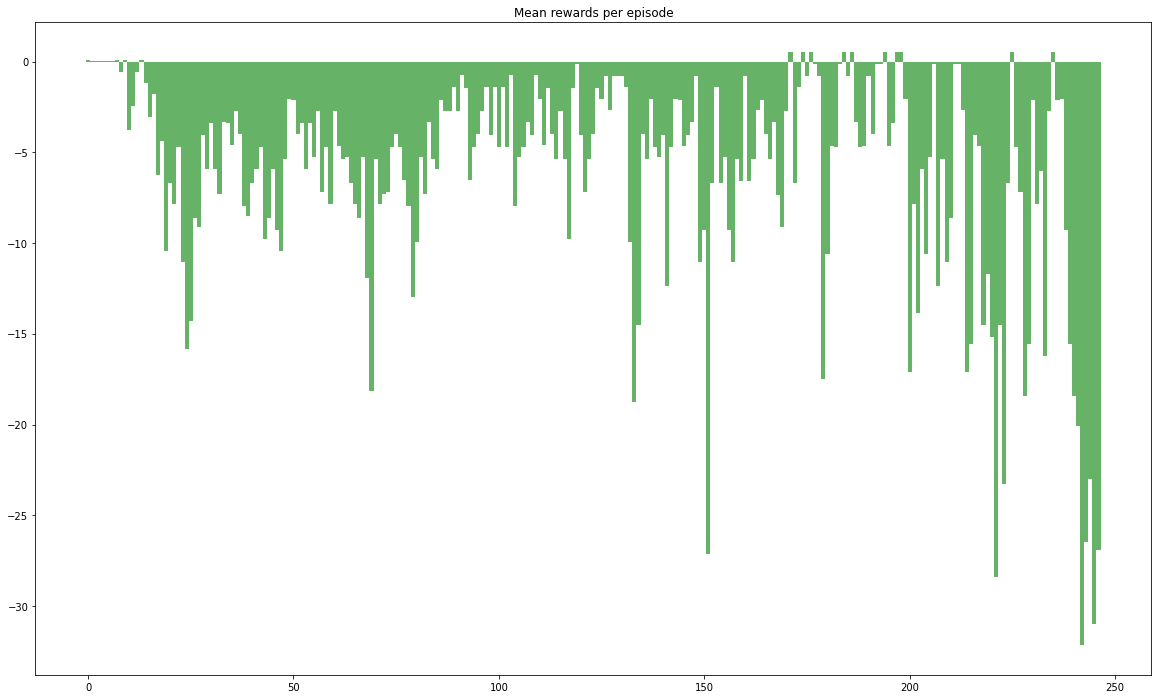

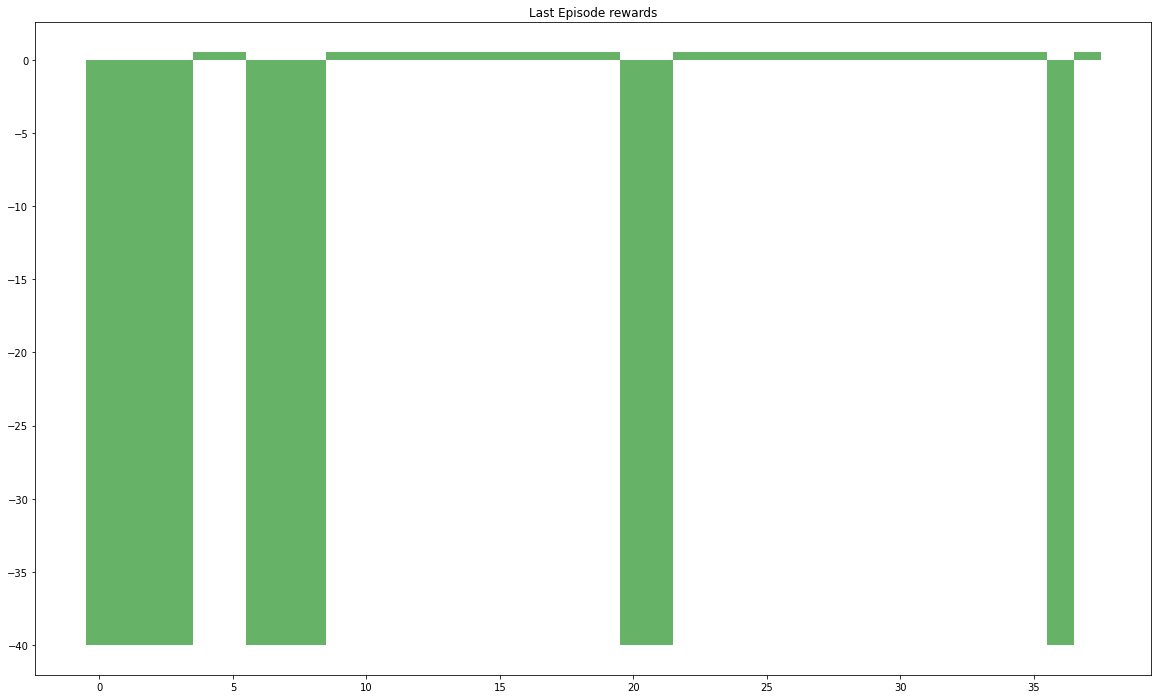

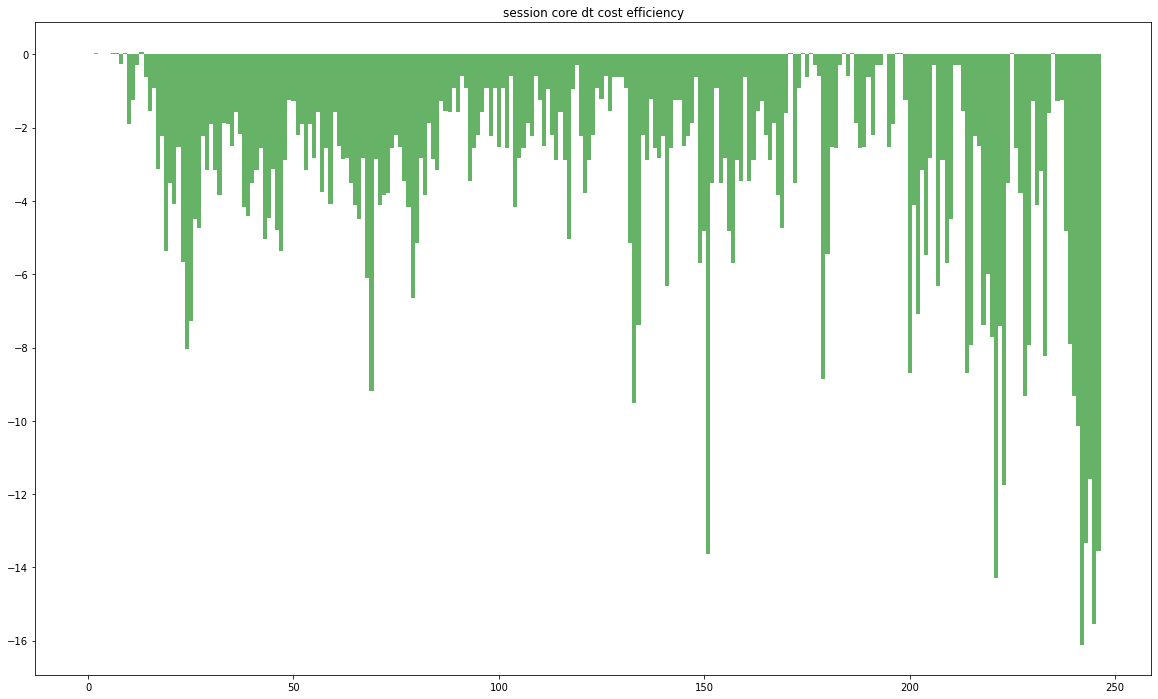

count    247.000000
mean      -3.172049
std        2.954299
min      -16.119545
25%       -4.096907
50%       -2.536734
75%       -1.237218
max        0.061629
dtype: float64


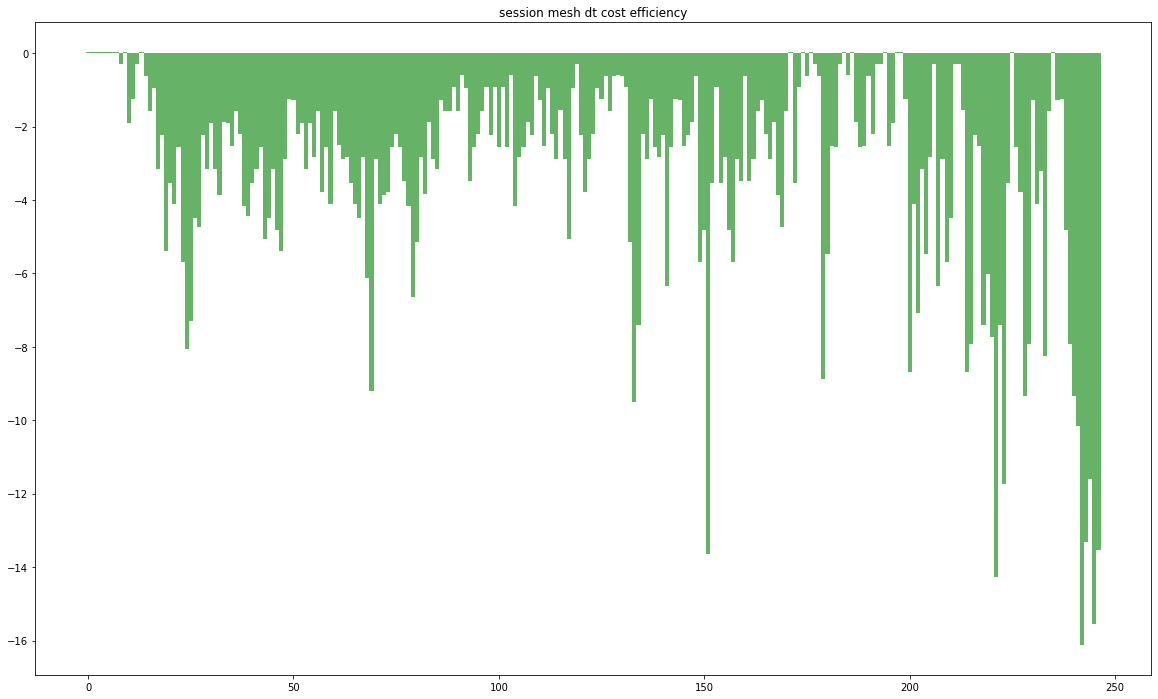

count    247.000000
mean      -3.179264
std        2.953647
min      -16.123491
25%       -4.104398
50%       -2.554908
75%       -1.245225
max        0.029043
dtype: float64


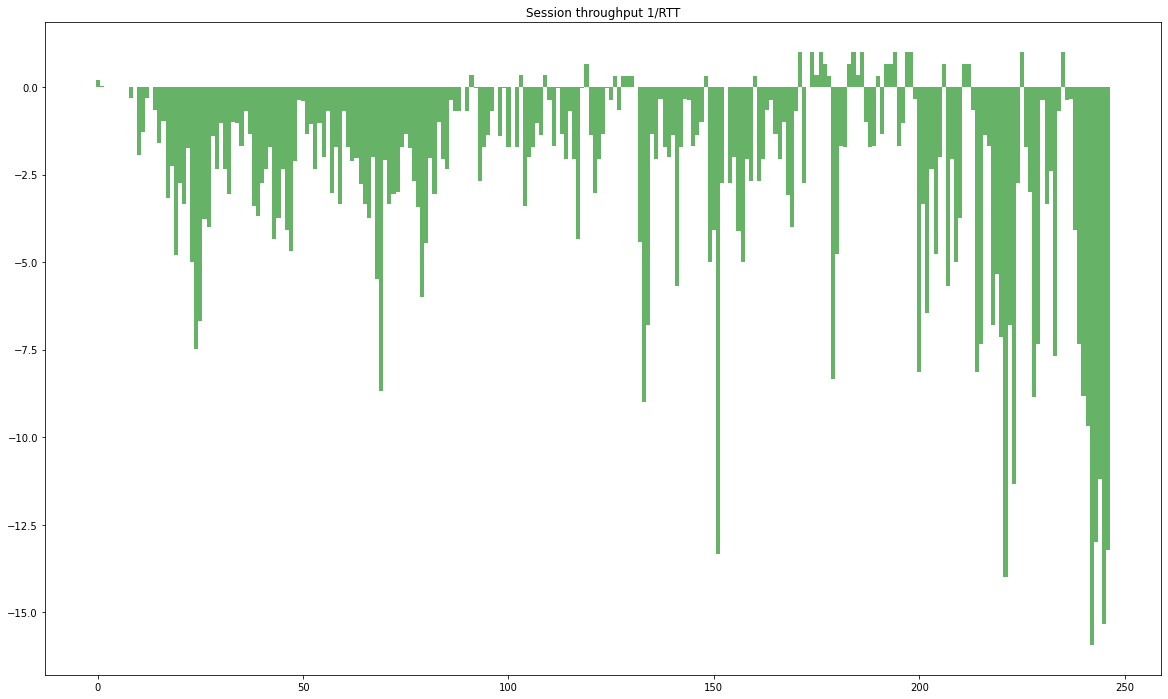

count    247.000000
mean      -2.441535
std        3.042071
min      -15.935484
25%       -3.333333
50%       -1.709677
75%       -0.354839
max        1.000000
dtype: float64


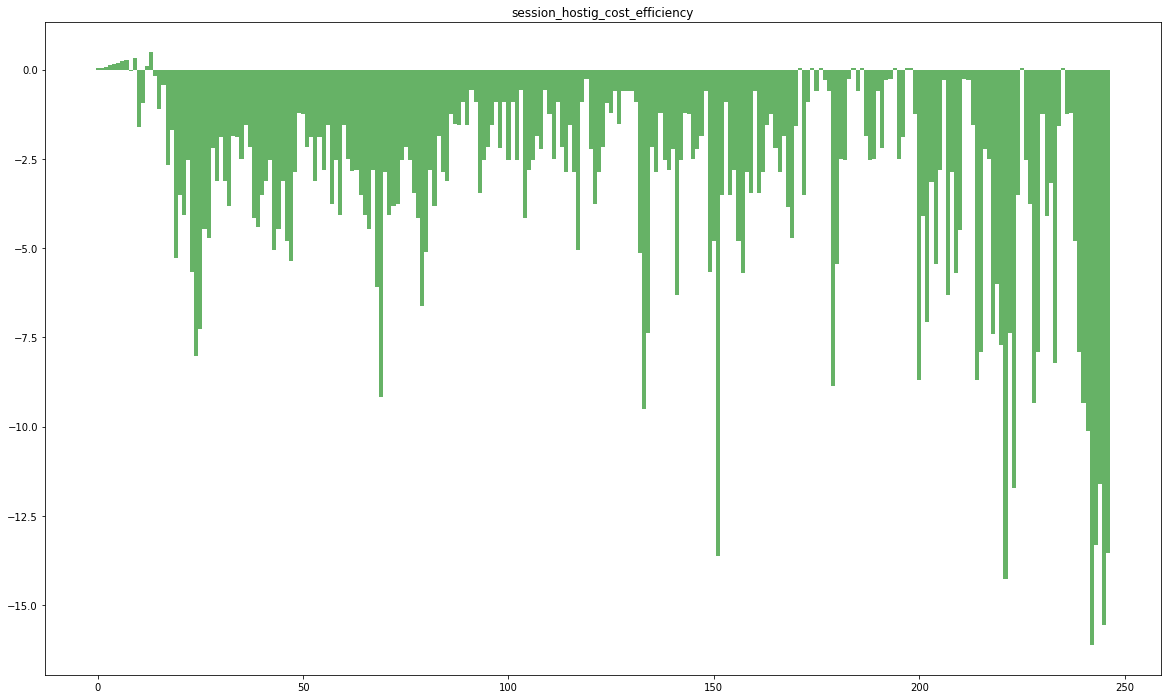

count    247.000000
mean      -3.141823
std        2.971567
min      -16.119041
25%       -4.083402
50%       -2.533408
75%       -1.226760
max        0.487378
dtype: float64
LAST EPISODE:


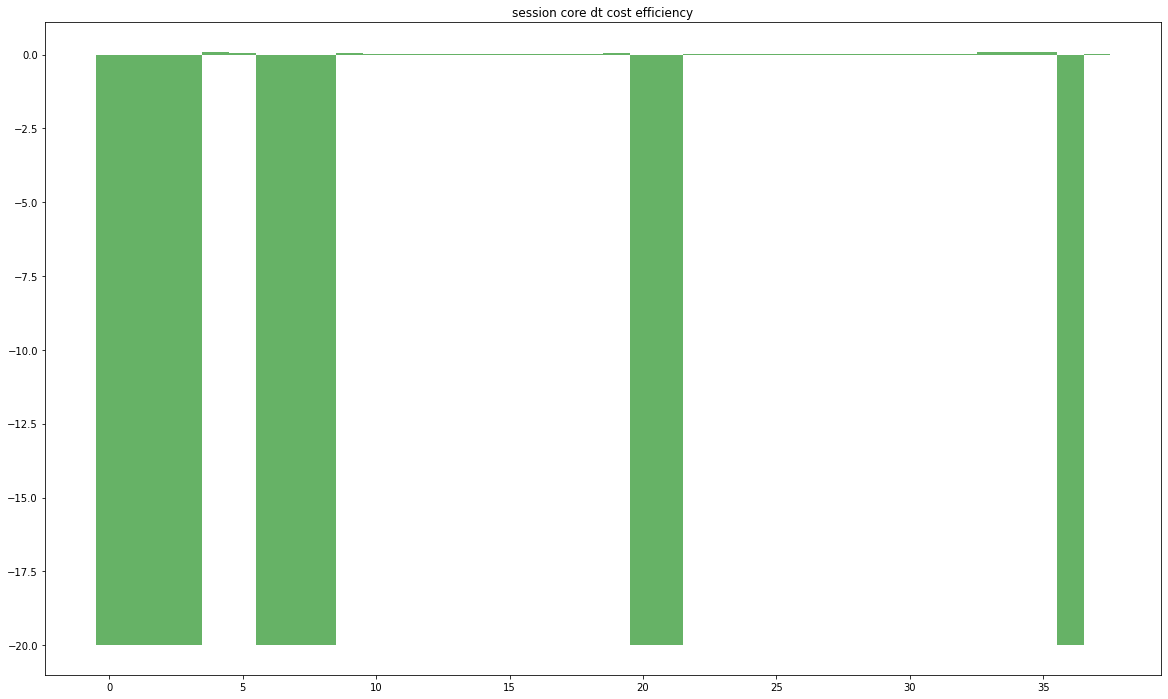

count    38.000000
mean     -5.241107
std       8.938545
min     -20.000000
25%     -14.997472
50%       0.020326
75%       0.021935
max       0.086523
dtype: float64


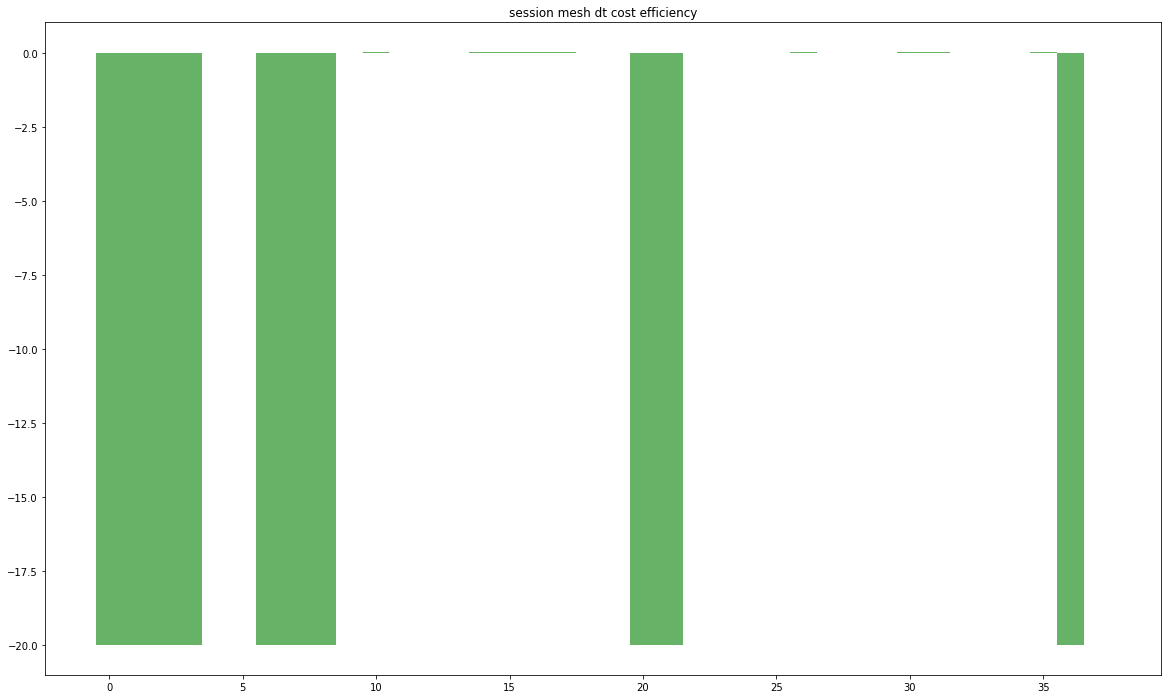

count    38.000000
mean     -5.244330
std       8.936571
min     -20.000000
25%     -14.995235
50%       0.023913
75%       0.025446
max       0.037948
dtype: float64


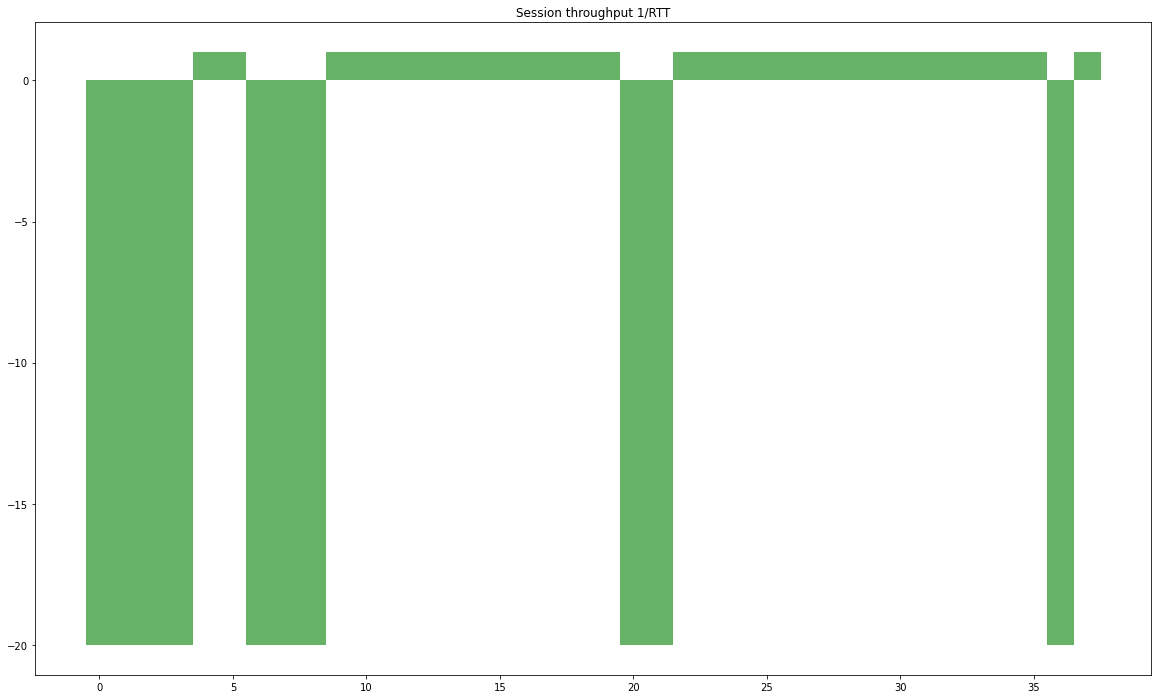

count    38.000000
mean     -4.526316
std       9.371428
min     -20.000000
25%     -14.750000
50%       1.000000
75%       1.000000
max       1.000000
dtype: float64


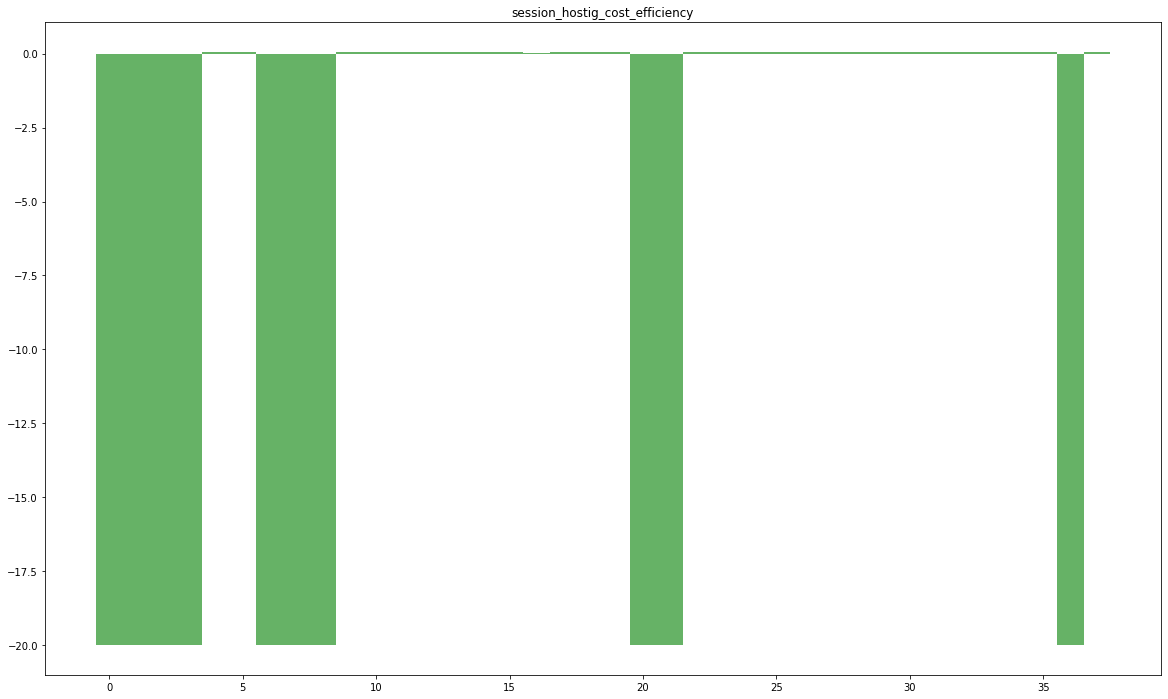

count    38.000000
mean     -5.230419
std       8.944995
min     -20.000000
25%     -14.990489
50%       0.042612
75%       0.045375
max       0.051478
dtype: float64


In [ ]:
print('Score weights:')

for key in simulator.assigner_score_weigths.keys():
  
  print(key, simulator.assigner_score_weigths[key])

plot_series(all_rewards, 'Mean rewards per episode')

plot_series(rewards, 'Last Episode rewards')

plot_stats(all_sess_stats_tuples, step=1)

print('LAST EPISODE:')

plot_stats(sess_stats_tuples, step=1)

#plot_net_stats(net_stats_tuples)


#### We now use the advantage actor critic framework:
____________________

In [ ]:
class AssignmentActorCriticNetwork(nn.Module):


  def __init__(self, num_of_hosting_nodes, request_tensor_dim, hidden_linear_dim):

    super(AssignmentActorCriticNetwork, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(1,2), stride=(1,2))

    self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1,2))

    self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1,2))

    self.conv4 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(1,2))


    self.linear_input_dim = (2 * num_of_hosting_nodes) + request_tensor_dim

    self.actor_linear1 = nn.Linear(in_features=self.linear_input_dim, out_features=hidden_linear_dim)

    self.actor_linear2 = nn.Linear(in_features=hidden_linear_dim, out_features=hidden_linear_dim)

    self.actor_linear3 = nn.Linear(in_features=hidden_linear_dim, out_features=num_of_hosting_nodes)

    self.actor_softmax = nn.Softmax(dim=2)


    self.critic_linear1 = nn.Linear(in_features=self.linear_input_dim, out_features=hidden_linear_dim)

    self.critic_linear2 = nn.Linear(in_features=hidden_linear_dim, out_features=int(hidden_linear_dim/4))

    self.critic_linear3 = nn.Linear(in_features=int(hidden_linear_dim/4), out_features=1)

    self.relu = nn.ReLU()



  def forward(self, net_state_tensor, input_req_tensor, residual_link_tensor):

      x = net_state_tensor

      x = self.conv1(x)

      x = self.relu(x)

      x = self.conv2(x)

      x = self.relu(x)

      x = self.conv3(x)

      x = self.relu(x)

      x = self.conv4(x)

      x = self.relu(x)

      x = torch.cat((x,residual_link_tensor.unsqueeze(3), input_req_tensor.unsqueeze(3)),dim=2).view(-1,1,self.linear_input_dim)

      actor = self.actor_linear1(x)

      actor = self.relu(actor)

      actor = self.actor_linear2(actor)

      actor = self.relu(actor)

      actor = self.actor_linear3(actor)

      policy = self.actor_softmax(actor)


      critic = self.critic_linear1(x)

      critic = self.relu(critic)

      critic = self.critic_linear2(critic)

      critic = self.relu(critic)

      advantage = self.critic_linear3(critic)

      return advantage, policy


In [ ]:
import random 

random.seed(777)

learning_rate = 0.05

num_episodes = 900

gamma = 0.9

hidden_layer = 512

max_steps_per_episode = 100

report_interval = 1


##### Train!

Output streaming troncato alle ultime 5000 righe.
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
episode: 838, avg rewards: -10.0 

core_dt_cost_eff tensor(-20.)
mesh_dt_cost_eff tensor(-20.)
sess_QoS tensor(-20.) calc by -500 over 25
hosting_cost_eff tensor(-20.)
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
episode: 839, avg rewards: -10.0 

core_dt_cost_eff tensor(-20.)
mesh_dt_cost_eff tensor(-20.)
sess_QoS tensor(-20.) calc by -500 over 25
hosting_cost_eff tensor(-20.)
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
op

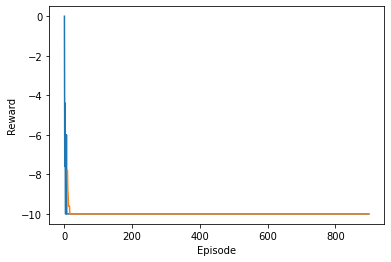

In [ ]:
N_cp = 41

N_uc = 4

N_h = 16

simulator = CDNSimulator(requests_ds=optimized_DS, 
                         num_of_hosting_nodes=N_h, 
                         mm1_delay_model=True, 
                         training=True)

net_state, reqs_to_process = simulator.reset()


request_tensor_dim = 1 + 1 + N_cp + N_uc

net = AssignmentActorCriticNetwork(num_of_hosting_nodes=N_h, 
                                   request_tensor_dim=request_tensor_dim, 
                                   hidden_linear_dim=hidden_layer).to(device)

optimizer = optim.Adam(params=net.parameters(), lr=learning_rate)

loss_func = nn.MSELoss()

#self.loss_func = nn.SmoothL1Loss()

all_rewards = []

entropy_term = 0

all_stats_tuples = []

#net_stats_tuples = []

prev_action = None


for episode in range(num_episodes):

    log_probs = []

    values = []

    rewards = []

    stats_tuples = []

    if simulator.timesteps >= 5760:

      print('\nresetting simulator\n')

      net_state, reqs_to_process = simulator.reset()

    for steps in range(max_steps_per_episode):

      while len(reqs_to_process) == 0: 

            net_state, reqs_to_process = simulator.take_greedy_adaptation_action()

      curr_net_state_tensor, curr_req_tensor = preprocess_state(net_state, reqs_to_process)

      curr_link_tensor = get_link_tensor(simulator,reqs_to_process[-1],prev_action).to(device)

      value, policy_dist = net(curr_net_state_tensor, curr_req_tensor, curr_link_tensor)

      value = value.detach().squeeze().item()

      dist = policy_dist.detach().cpu() 

      action = np.random.choice(N_h, p=np.squeeze(dist.numpy().squeeze(0)))

      prev_action = action

      log_prob = torch.log(policy_dist.squeeze(0)[0][action])

      entropy = - torch.sum(torch.mean(dist) * torch.log(dist))

      net_state, reqs_to_process, assignation_reward, _, stats_tuple, net_stats_tuple = simulator.assignation_step(action)

      if stats_tuple != (0,0,0,0) : stats_tuples.append(stats_tuple)

      #if net_stats_tuple != (0,0,0,0) : net_stats_tuples.append(net_stats_tuple)

      while len(reqs_to_process) == 0: 

        net_state, reqs_to_process = simulator.take_greedy_adaptation_action()

      rewards.append(assignation_reward)

      values.append(value)

      log_probs.append(log_prob)

      entropy_term += entropy
      
      if steps == max_steps_per_episode-1:

        curr_net_state_tensor, curr_req_tensor = preprocess_state(net_state, reqs_to_process)

        curr_link_tensor = get_link_tensor(simulator,reqs_to_process[-1],prev_action).to(device)

        Q_val, _ = net(curr_net_state_tensor, curr_req_tensor, curr_link_tensor)

        Q_val = Q_val.detach().squeeze().item()

        mean_reward = np.mean(rewards)

        all_rewards.append(mean_reward)

        mean_sess_stats = torch.mean(torch.cat(([torch.Tensor(sess_stats_tuple) for sess_stats_tuple in stats_tuples])).view(-1,4), dim=0)

        all_stats_tuples.append(mean_sess_stats)


        if episode % 1 == 0:                    
            print("episode: {}, avg rewards: {} \n".format(episode, mean_reward ))         
            print('core_dt_cost_eff', mean_sess_stats[0])
            print('mesh_dt_cost_eff', mean_sess_stats[1])
            print('sess_QoS', mean_sess_stats[2], 'calc by', np.sum([a[2] for a in stats_tuples]), 'over' , len(stats_tuples))
            print('hosting_cost_eff', mean_sess_stats[3])
        break
    
    # compute Q values
    Qvals = np.zeros_like(values)

    for t in reversed(range(len(rewards))):

        Q_val = rewards[t] + gamma * Q_val
        
        Qvals[t] = Q_val

    #update actor critic
    values = torch.FloatTensor(values).to(device)

    Qvals = torch.FloatTensor(Qvals).to(device)

    log_probs = torch.stack(log_probs).to(device)
    
    advantages = Qvals - values

    actor_loss = (-log_probs * advantages).mean()

    critic_loss = 0.5 * advantages.pow(2).mean()

    ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

    optimizer.zero_grad()

    ac_loss.backward()

    optimizer.step()

    

# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()

smoothed_rewards = [elem for elem in smoothed_rewards]

plt.plot(all_rewards)

plt.plot(smoothed_rewards)

plt.plot()

plt.xlabel('Episode')

plt.ylabel('Reward')

plt.show()

##### Plot Results:

In [ ]:
print('Score weights:')

for key in simulator.assigner_score_weigths.keys():
  
  print(key, simulator.assigner_score_weigths[key])

plot_series(all_rewards, 'Sum of  rewards per episode')

mean_rewards = (np.array(all_rewards) / 3600)

plot_series(mean_rewards, 'Mean rewards per episode')

plot_series(rewards, 'Last Episode rewards')

plot_stats(all_stats_tuples)

plot_stats(stats_tuples)

#plot_net_stats(net_stats_tuples)

plot_session_utilization_stats(session_opt_dev_tuples)

Score weights:


NameError: ignored

Score weights:
core_dt_cost_eff 0.3
mesh_dt_cost_eff 0.2
qos 0.3
hosting_cost_efficiency 0.2


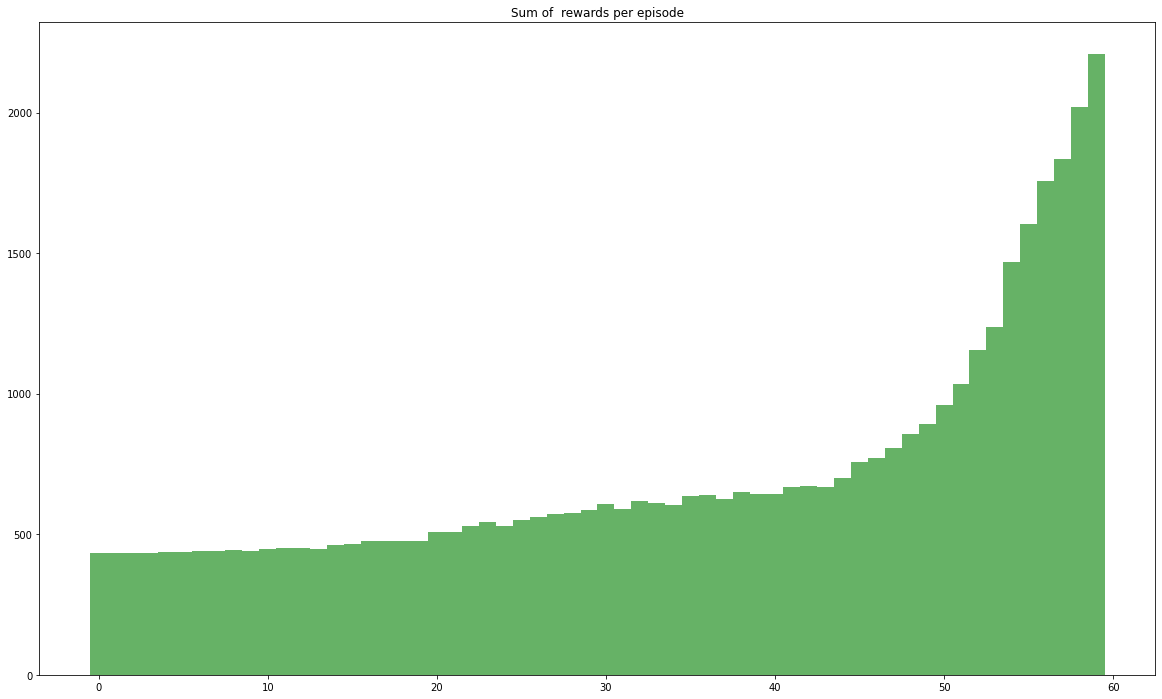

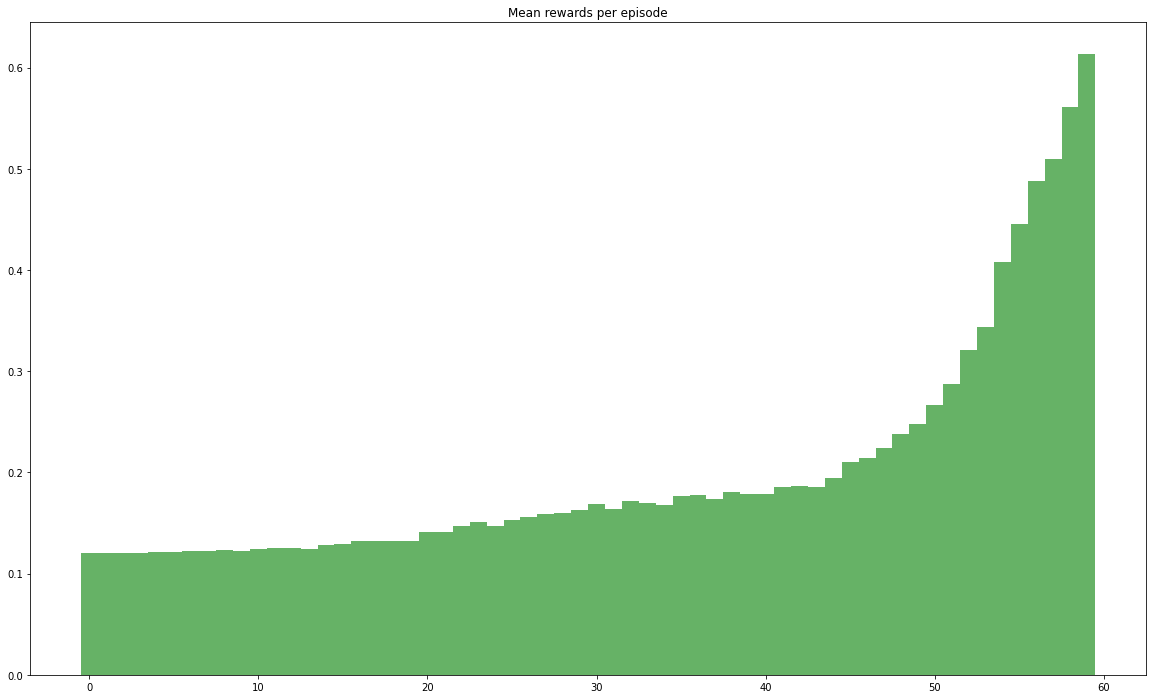

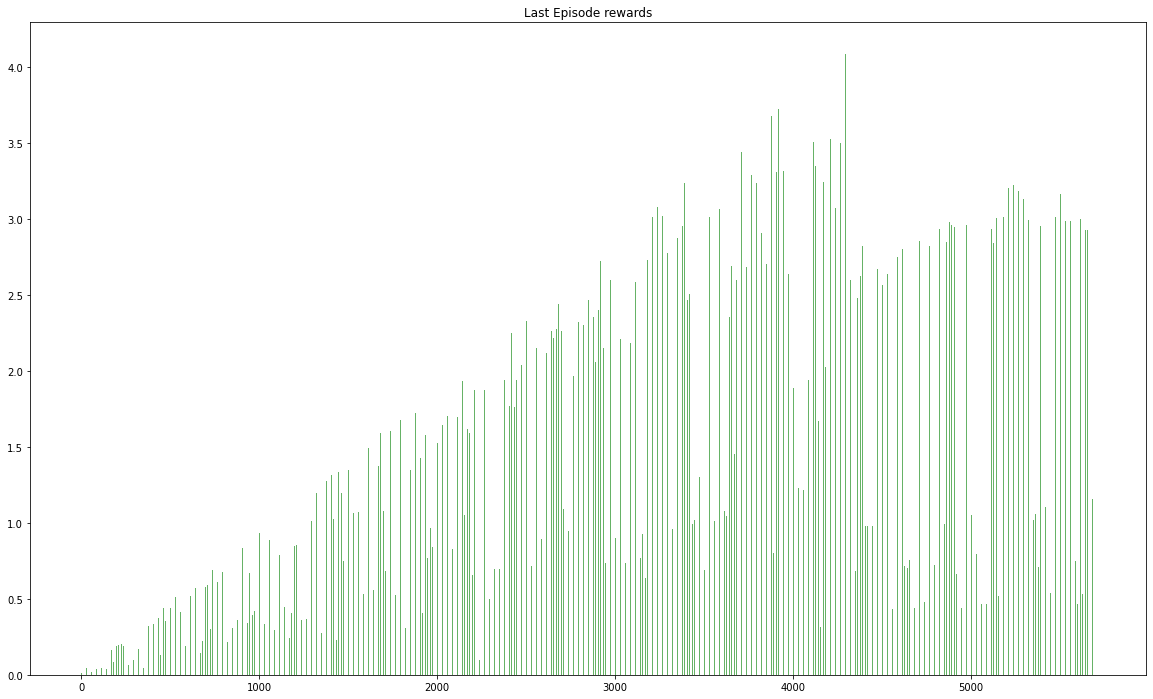

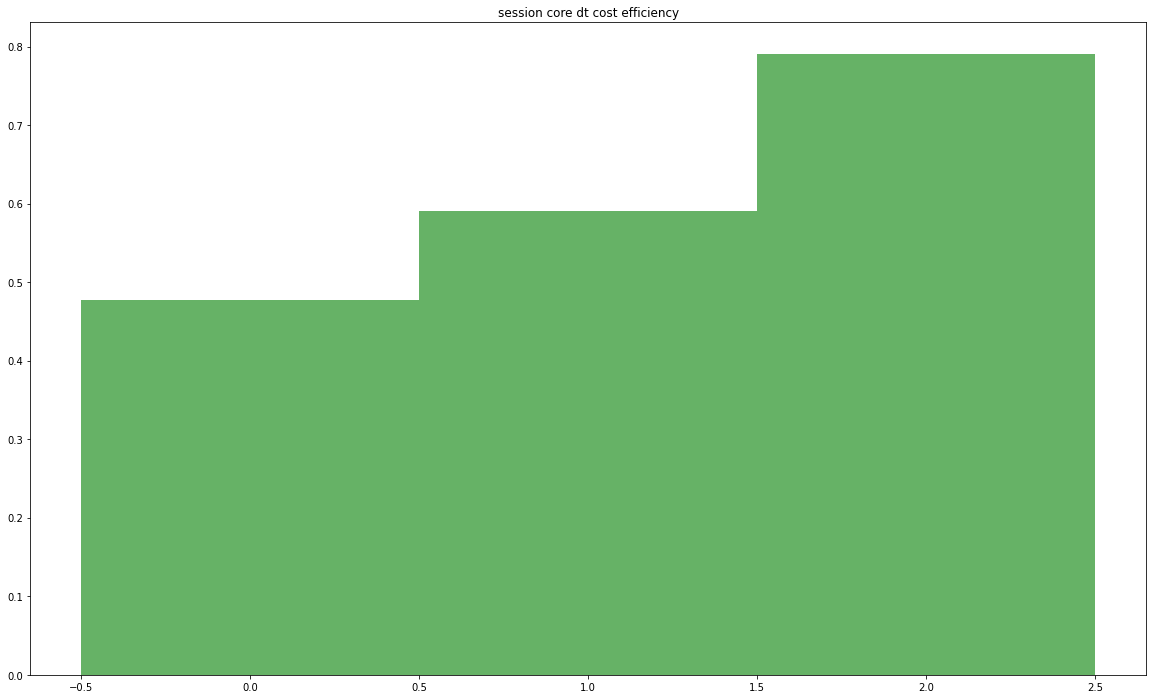

count    3.000000
mean     0.619914
std      0.158858
min      0.477403
25%      0.534276
50%      0.591148
75%      0.691169
max      0.791189
dtype: float64


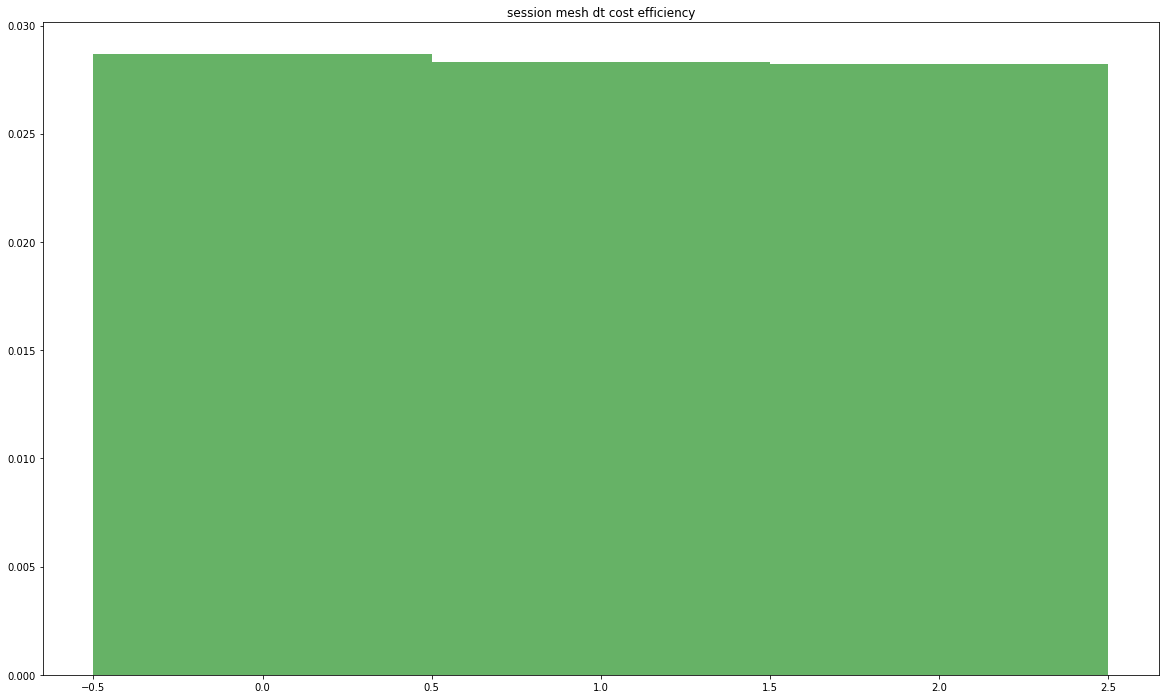

count    3.000000
mean     0.028420
std      0.000250
min      0.028242
25%      0.028278
50%      0.028313
75%      0.028509
max      0.028706
dtype: float64


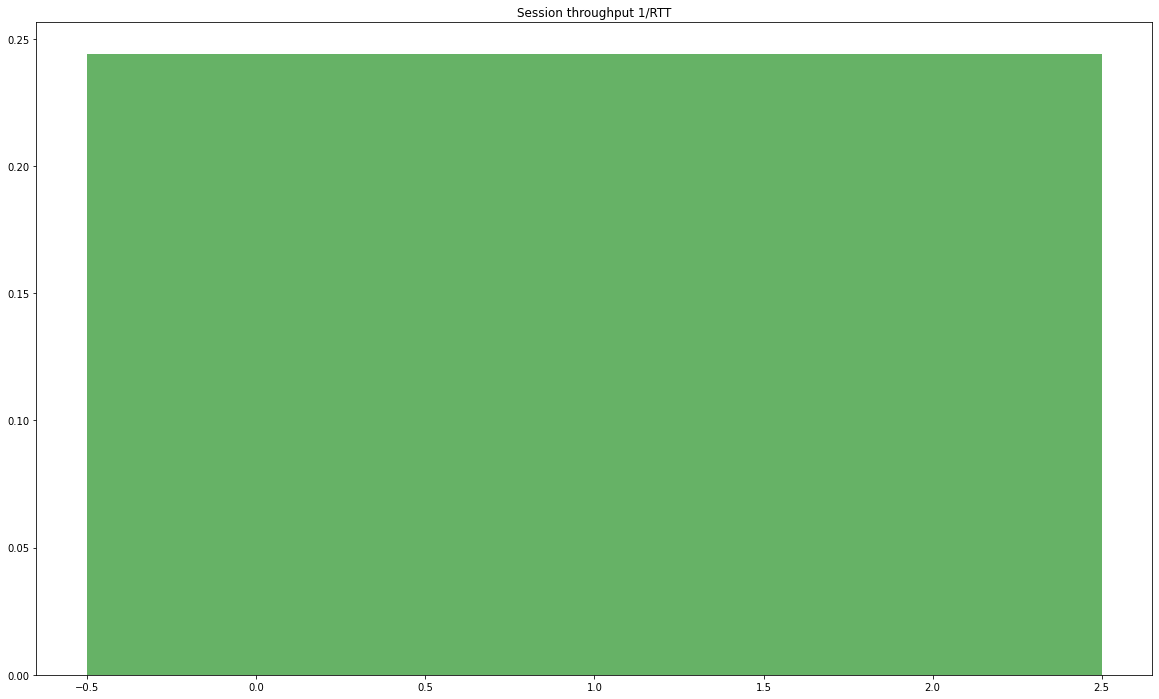

count    3.000000
mean     0.244211
std      0.000000
min      0.244211
25%      0.244211
50%      0.244211
75%      0.244211
max      0.244211
dtype: float64


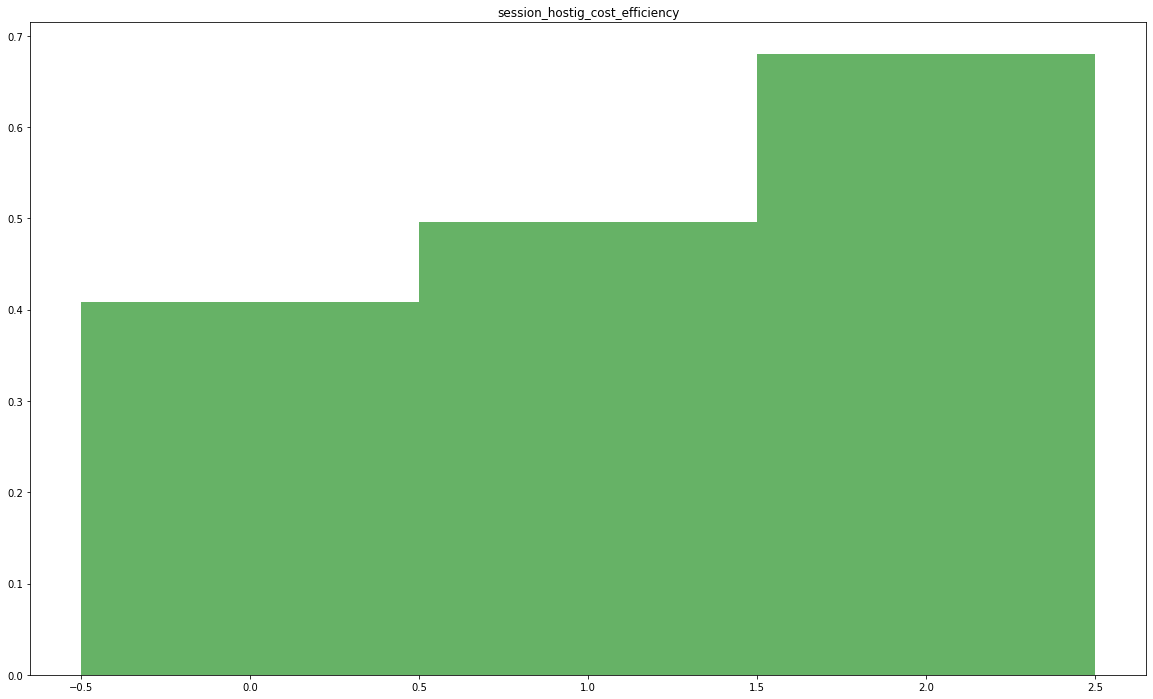

count    3.000000
mean     0.528241
std      0.139094
min      0.408078
25%      0.452054
50%      0.496030
75%      0.588322
max      0.680615
dtype: float64


NameError: ignored

In [ ]:
print('Score weights:')

for key in simulator.assigner_score_weigths.keys():
  
  print(key, simulator.assigner_score_weigths[key])

plot_series(all_rewards, 'Sum of  rewards per episode')

mean_rewards = (np.array(all_rewards) / 3600)

plot_series(mean_rewards, 'Mean rewards per episode')

plot_series(rewards, 'Last Episode rewards')

plot_stats(all_stats_tuples)

plot_stats(stats_tuples)

#plot_net_stats(net_stats_tuples)

plot_session_utilization_stats(session_opt_dev_tuples)

In [ ]:
len(all_stats_tuples)

18

In [ ]:
len(simulator.sessions_dict)

1255

### Adapter Agent:
_________________

#### REINFORCE:
___________________

In [ ]:
v = get_capacities_tensor(simulator.ns)

In [ ]:
v.shape

torch.Size([2, 16, 12])

In [ ]:
v.view(-1).shape

torch.Size([384])

In [ ]:
q = torch.nn.Conv3d(in_channels=1, out_channels=64, kernel_size=(1,1,2), stride=(1,1,2))

w = torch.nn.Conv3d(in_channels=64, out_channels=32, kernel_size=(1,1,3), stride=(1,1,3))

e = torch.nn.Conv3d(in_channels=32, out_channels=16, kernel_size=(1,1,4))

r = torch.nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(1,4), stride=(1,4))

In [ ]:
ct = e(w(q(v.unsqueeze(0).unsqueeze(0))))

In [ ]:
r(ct.squeeze(4)).shape

torch.Size([1, 1, 41, 4])

In [ ]:
rt = request_cubes_25[0]

In [ ]:
a = torch.nn.Conv3d(in_channels=1, out_channels=1, kernel_size=(1,1,2), dilation=(1,1,2))

b = torch.nn.Conv3d(in_channels=1, out_channels=1, kernel_size=(1,1,2), dilation=(1,1,4))

c = torch.nn.Conv3d(in_channels=1, out_channels=1, kernel_size=(1,1,2), dilation=(1,1,8))

In [ ]:
rt_proc = c(b(a(rt.unsqueeze(0).unsqueeze(0))))

In [ ]:
rt_proc.view(-1).shape

torch.Size([164])

In [ ]:
conv1 = torch.nn.Conv2d(in_channels=2, out_channels=64, kernel_size=(1))

conv2 = torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1))

conv3 = torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1))

conv4 = torch.nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(1))

In [ ]:
v = get_capacities_tensor(simulator.ns)

rt = request_cubes_25[0]

In [ ]:
v.shape

torch.Size([2, 16, 12])

In [ ]:
net = AdapterPolicyNetwork()

In [ ]:
net(v.unsqueeze(0),rt.unsqueeze(0).unsqueeze(0)).shape

torch.Size([192])

In [ ]:
class AdapterPolicyNetwork(nn.Module):
  '''
  INPUTS: 
  -capacities tensor

  OUTPUTS:
    The adaptation tensor.
  '''

  def __init__(self):

      super(AdapterPolicyNetwork, self).__init__()

      self.conv_net_state_1 = torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(1))

      self.conv_net_state_2 = torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1))

      self.conv_net_state_3 = torch.nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(1))

      self.conv_input_traffic_1 = torch.nn.Conv3d(in_channels=1, out_channels=1, kernel_size=(1,1,2), dilation=(1,1,2))

      self.conv_input_traffic_2 = torch.nn.Conv3d(in_channels=1, out_channels=1, kernel_size=(1,1,2), dilation=(1,1,4))

      self.conv_input_traffic_3 = torch.nn.Conv3d(in_channels=1, out_channels=1, kernel_size=(1,1,2), dilation=(1,1,8))

      self.final_fully_conn_1 = torch.nn.Linear(in_features=356, out_features=512)

      self.final_fully_conn_2 = torch.nn.Linear(in_features=512, out_features=512)

      self.final_fully_conn_3 = torch.nn.Linear(in_features=512, out_features=192)


  def forward(self, net_state, input_traffic):

    x = self.conv_net_state_1(net_state)

    x = self.conv_net_state_2(x)

    x = self.conv_net_state_3(x)

    x = x.view(-1)

    y = self.conv_input_traffic_1(input_traffic)

    y = self.conv_input_traffic_2(y)

    y = self.conv_input_traffic_3(y)

    y = y.view(-1)

    z = torch.cat((x,y))

    z = self.final_fully_conn_1(z)

    z = self.final_fully_conn_2(z)

    z = self.final_fully_conn_3(z)

    return z

